# Einführung Neuronale Netzwerke
Thomas Liebig - 2025

Eine Kopie des Notebooks dass diesen Unterlagen zugrunde liegt, finden Sie unter [github](https://github.com/thomasliebig/jupyterlite).

Sie können dies z.B. in dem jupyter lab auf der von mir bereitgestellten virtuellen Maschine [github](https://github.com/thomasliebig/RISE-environment) ausführen.

In [4]:
%%writefile transformerhelper.py

from manim import *

from manim import config as global_config
config = global_config.copy()
myTemplate = TexTemplate()
myTemplate.add_to_preamble(r"\usepackage{mathrsfs}")
myTemplate.add_to_preamble(r"\usepackage[sfmath,lighttext]{kpfonts}")
myTemplate.add_to_preamble(r"\usepackage{amsmath,MnSymbol,wasysym}")  
myTemplate.add_to_preamble(r"\renewcommand{\familydefault}{\sfdefault}")  # Set non-serif for text

config["tex_template"] = myTemplate
config.tex_template=myTemplate

import numpy as np
from scipy.special import softmax

from typing import List

background = "#2C3E50"
highlight1 = "#1ABC9C" # pink
highlight2 = "#E67E22" # blue
text_c = "#ECF0F1"
    
VOCAB = {
    'the': 3206,
    'robots': 2736,
    'will': 3657,
    'bring': 400,
    'prosperity': 2532,
    'aardvark': 14,
    'apple': 177,
    'box': 392,
    'cardboard': 477
}

WORD_EMB = {
    'the': [0.07213349, 0.13476127, 0.63486506, 0.234234],
    'robots': [0.8144936 , 0.51136212, 0.43797063, 0.9834],
    'will': [0.61763848, 0.29474857, 0.80120351, 0.3444],
    'bring': [0.5001875 , 0.15730688, 0.93133526, 0.19484],
    'prosperity': [0.2479659 , 0.41104862, 0.23145515, 0.74674]
}

POS_EMB = {
    '0': [0.3204288 , 0.11540252, 0.88234465, 0.74674],
    '1': [0.14030786, 0.07085044, 0.40712213, 0.3458],
    '2': [0.07433667, 0.47350997, 0.22633834, 0.85674],
    '3': [0.80512473, 0.1189765 , 0.0632117, 0.2377]
}

class BaseScene(Scene):
    """Capture common methods for all scenes."""

    ANIM_SPEED = 1.5
    Text.set_default(font="Noto Sans")  # Example: Arial is a non-serif font
    

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.camera.background_color = background
        Mobject.set_default(color=text_c)
        Text.set_default(color=text_c)     # Set default text color for Text objects
        MathTex.set_default(color=text_c)  # Set default text color for MathTex objects
        Tex.set_default(color=text_c)      # Set default text color for Tex objects
        Arrow.set_default(stroke_color=text_c)
        Line.set_default(stroke_color=text_c)
        Brace.set_default(stroke_color=text_c)

    def wait(self, num_secs=1):
        super().wait(num_secs * BaseScene.ANIM_SPEED)
    
    def play(self, *args, **kwargs):
        if 'run_time' in kwargs:
            kwargs['run_time'] *= BaseScene.ANIM_SPEED
        else:
            kwargs['run_time'] = 1.2
        super().play(*args, **kwargs)
    
    def _make_matrix(self, embeddings, actual_h=None, actual_w=None):
        h, w = len(embeddings), len(embeddings[0])
        actual_h = actual_h or h
        actual_w = actual_w or w
        tr_input = []
        for row in embeddings:
            tr_row = [ MathTex(f'{e:.2f}') for e in row ]
            if actual_w > w:
                tr_row = tr_row[:2] + [tr_row[-1]]
                tr_row.insert(-1, MathTex("\\dots"))
            tr_input.append(tr_row)
        if actual_h > h:
            tr_input.append([MathTex("\\vdots") for i in range(len(tr_input[-1]))])
        return MobjectMatrix(tr_input)

    def _make_row_labels(self, matrix, labels, color=highlight1, dir=LEFT):
        rows = matrix.get_rows()
        text_objs = []
        for row, label in zip(rows, labels):
            text_objs.append(Text(label, font_size=24).next_to(row, dir * 3).set_color(color))
        return VGroup(*text_objs)
    

class TwoColumnMapping(BaseScene):

    def __init__(self, text="robots", embeddings=WORD_EMB, xlabel=None, ylabel=None, quote_tokens=True, show_dot_row=False, **kwargs):
        self.text = text
        self.vectors = [embeddings[t] for t in text.split(' ')]
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.quote_tokens = quote_tokens
        self.show_dot_row = show_dot_row
        super().__init__(**kwargs)

    def construct(self):
        self.camera.background_color = background
        Text.set_default(color=text_c)
        MathTex.set_default(color=text_c)
        Arrow.set_default(color=text_c)
        BraceLabel.set_default(color=text_c)

        self.show_embeddings() 
    
    def show_embeddings(self):
        words = self.text.split(' ')

        grid = VGroup()
        word_group = VGroup()
        vector_group = VGroup()
        arrow_group = VGroup()

        for (i, word) in enumerate(words):
            word_obj = Text(f'"{word}"') if self.quote_tokens else Text(word)
            arrow_obj = Arrow(start=LEFT, end=RIGHT)
            word_value = self.vectors[i]
            if not isinstance(word_value, list):
                word_value = [word_value]
            embedding = [ MathTex(f'{x:.2f}') if isinstance(x, float) else MathTex(x) for x in word_value ]
            if len(embedding) > 1:
                embedding.insert(-1, MathTex("\\dots"))

            vector_obj = VGroup(*list(embedding))
            vector_obj.arrange()

            grid += word_obj
            grid += arrow_obj
            grid += vector_obj

            word_group += word_obj
            vector_group += vector_obj
            arrow_group += arrow_obj

        if self.show_dot_row:
            word_dots = MathTex("\\vdots")
            grid += word_dots
            word_group += word_dots
            dot_arrow = Arrow(start=LEFT, end=RIGHT)
            arrow_group += dot_arrow
            grid += dot_arrow
            vector_dots = MathTex("\\vdots")
            vector_group += vector_dots
            grid += vector_dots

        grid.arrange_in_grid(len(words) if not self.show_dot_row else len(words) + 1, 3, buff=0.4)

        if self.xlabel:
            word_brace = BraceLabel(grid, self.xlabel, brace_direction=LEFT).set_color(highlight1)
            word_brace.label.rotate(np.pi / 2).set_color(highlight1).shift(RIGHT * 0.5)

        if self.ylabel:
            dim_brace = BraceLabel(vector_group, self.ylabel, brace_direction=UP).set_color(highlight2)

        self.add(word_group)
        if self.xlabel:
            self.play(FadeIn(word_brace))
        self.play(FadeIn(arrow_group))
        if self.ylabel:
            self.play(FadeIn(vector_group, dim_brace))
        else:
            self.play(FadeIn(vector_group))

        self.wait(4)

class TransformerFunc(BaseScene):

    def __init__(self, show_tokenization=True, **kwargs):
        super().__init__(**kwargs)
        self.show_tokenization = show_tokenization

        # Light mode
        self.camera.background_color = background
        Text.set_default(color=text_c)
        MathTex.set_default(color=text_c)
        Line.set_default(color=text_c)
        Rectangle.set_default(color=text_c)

    def construct(self):

        title1 = Title("The Transformer function", match_underline_width_to_text=True)
        title2 = Title("Given word sequence, return next word", match_underline_width_to_text=True)
        title3 = Text("...with tokenization").move_to(UP * 2).scale(0.6)
        subtext = MathTex("\\theta\\text{: model parameters}").move_to(DOWN * 2).scale(0.8)
        subtext_box = SurroundingRectangle(subtext).set_color(text_c)

        p1 = MathTex("Transformer(")
        p2 = MathTex("X").set_color(highlight2)
        p3 = MathTex(", \\theta) \\rightarrow")
        p4 = MathTex("Y").set_color(highlight1)
        eq_group = VGroup(p1, p2, p3, p4)
        eq_group.arrange()

        sentence = "the robots will bring prosperity".split(' ')
        prompt = sentence[:-1]
        answer = sentence[-1]
        p2_words = MathTex('``' + '\\;'.join(prompt) + '"').shift(LEFT).set_color(highlight2)
        p4_word = MathTex(f'``{answer}"').next_to(p2_words, RIGHT * 5).set_color(highlight1)

        prompt_token_ids = [VOCAB[word] for word in prompt]
        p2_ids = MathTex(str(prompt_token_ids)).set_color(highlight2)
        p4_id = MathTex(str(VOCAB[answer])).next_to(p2_ids, RIGHT * 5).set_color(highlight1)

        self.play(LaggedStart(
            Write(title1), 
            FadeIn(eq_group), FadeIn(subtext), Create(subtext_box),
            lag_ratio=0.3,
            run_time=3))
        self.wait(2)
        eq_group = VGroup(p1, p2_words, p3, p4_word)
        self.play(
            FadeOut(title1), Write(title2),
            FadeOut(p2, p4), FadeIn(p2_words, p4_word), eq_group.animate.arrange())
        self.wait(2)

        if self.show_tokenization:
            eq_group = VGroup(p1, p2_ids, p3, p4_id)
            self.play(
                Write(title3),
                FadeOut(p2_words, p4_word), FadeIn(p2_ids, p4_id), eq_group.animate.arrange())

        self.wait(4)
        
class WordEmbeddings(BaseScene):

    def __init__(self,**kwargs):
        self.sentence = "the robots will bring"
        self.sentence_tokens = self.sentence.split(' ')
        super().__init__(**kwargs)
    
    def add_pos_labels(self, token_objs):
        labels = VGroup()
        for i, obj in enumerate(token_objs):
            label = MathTex(f'{i}', font_size=36)
            label.next_to(obj, UP, SMALL_BUFF)
            obj.add(label)
            labels.add(label)
        return labels
    
    def make_sentence_tokens(self):
        token_objs = VGroup(*[Text(t) for t in self.sentence_tokens])
        boxes = [SurroundingRectangle(t).set_color(highlight1) for t in token_objs]
        token_boxes = [VGroup(t, b) for (t, b) in zip(token_objs, boxes)]
        group = VGroup(*token_boxes)
        group.arrange(RIGHT, buff=0.5)
        return group
    
    def animate_sentence_tokens(self):
        token_group = self.make_sentence_tokens()
        num_tokens = len(token_group)
        token_boxes = [t[1] for t in token_group]
        self.play(*[FadeIn(t[0]) for t in token_group], run_time=1)

        self.play(*[Create(b) for b in token_boxes], run_time=1)
        self.play(
            token_group.animate.arrange_in_grid(num_tokens, 1, cell_alignment=RIGHT).shift(LEFT * 5).shift(DOWN), run_time=1)

        return token_group
    
    def animate_embeddings(self, prev_col, keys, embd_map):
        emb_arrows = [Arrow(start=LEFT, end=RIGHT).next_to(i, RIGHT, buff=MED_LARGE_BUFF) for i in prev_col]
        emb_rows = [ 
            [MathTex(f'{x:.2f}') for x in embd_map[t]] for (i, t) in enumerate(keys)]
        # Add ... to embedding vectors
        for row in emb_rows:
            row.insert(-1, MathTex("\\dots"))
        embs = [
            VGroup(*[VGroup(t, 
                            SurroundingRectangle(t)
                                .set_stroke(text_c, opacity=0 if i == len(row) - 2 else 1)) for (i, t) in enumerate(row)])
                .arrange(RIGHT, buff=0)
                .next_to(emb_arrows[i], buff=MED_LARGE_BUFF)
            for (i, row) in enumerate(emb_rows)
        ]
        embs_label = BraceLabel(embs[0], "C = 768", brace_direction=UP).set_color(highlight2)

        self.play(*[Create(a) for a in emb_arrows])
        self.play(*[FadeIn(a) for a in embs], FadeIn(embs_label))

        return VGroup(*embs)
    
    def construct(self):
        title = Title("Token embeddings", match_underline_width_to_text=True)
        self.add(title)

        token_group = self.animate_sentence_tokens()
        token_objs = [t[0] for t in token_group]

        id_arrows = [Arrow(start=LEFT, end=RIGHT).next_to(t, RIGHT, buff=MED_LARGE_BUFF) for t in token_objs]
        ids = [MathTex(str(VOCAB[t])).next_to(id_arrows[i], RIGHT, buff=MED_LARGE_BUFF) for (i, t) in enumerate(self.sentence_tokens)]
        ids_right_idx = np.argmax([id.get_right()[0] for id in ids])
        for id in ids:
            id.align_to(ids[ids_right_idx], RIGHT)

        self.play(*[Create(a) for a in id_arrows])
        self.play(*[FadeIn(a) for a in ids], FadeIn(BraceLabel(ids[0], "ID", UP).set_color(highlight1)))

        embedding_obj = self.animate_embeddings(ids, self.sentence_tokens, WORD_EMB)
        emb_matrix = self._make_matrix([WORD_EMB[w] for w in self.sentence_tokens], actual_w=768)
        emb_matrix.shift(DOWN * 0.5)

        self.wait(2)
        self.clear()
        title2 = Title("Token embedding matrix", match_underline_width_to_text=True)
        self.play(embedding_obj.animate.center().shift(DOWN * 0.5), Write(title2))
        self.wait()
        self.play(
            FadeOut(embedding_obj), FadeIn(emb_matrix), 
            FadeIn(BraceLabel(emb_matrix, "C = 768", UP).set_color(highlight2)), 
            FadeIn(BraceLabel(emb_matrix, f'T = {len(self.sentence_tokens)}', LEFT).set_color(highlight1))
        )

        self.wait(3)

class PositionEmbeddings(WordEmbeddings):

    def __init__(self, **kwargs):
        self.sentence = "the robots will bring"
        self.sentence_tokens = self.sentence.split(' ')
        super().__init__(**kwargs)

    def animate_sentence_tokens(self):
        token_group = self.make_sentence_tokens().scale(0.8) 
        num_tokens = len(token_group)
        token_boxes = [t[1] for t in token_group]
        self.play(*[FadeIn(t[0]) for t in token_group], run_time=1)

        token_labels = self.add_pos_labels(token_group)
        self.play(
            *[Create(b) for b in token_boxes],
            *[FadeIn(p) for p in token_labels], run_time=1)
        vert_labels = token_labels.copy()
        for l in vert_labels:
            l.set_color(highlight2)
        vert_group = VGroup(*[
            VGroup(l, SurroundingRectangle(l, buff=MED_SMALL_BUFF).set_color(highlight1))
            for l in vert_labels
        ]).scale(0.8) 
        vert_group.arrange_in_grid(num_tokens, 1, cell_alignment=RIGHT).shift(LEFT * 3).shift(DOWN * 1)
        
        self.play(*[TransformMatchingShapes(g, t) for (g, t) in zip(token_group, vert_group)], run_time=1)

        return vert_group
    
    def construct(self):
        title = Title("Position embeddings", match_underline_width_to_text=True)
        self.add(title)

        token_group = self.animate_sentence_tokens()
        emb_obj = self.animate_embeddings(token_group, [str(x) for x in range(len(self.sentence_tokens))], POS_EMB)
        emb_matrix = self._make_matrix([POS_EMB[str(i)] for i in range(len(self.sentence_tokens))], actual_w=768).scale(0.8) 
        emb_matrix.shift(DOWN * 0.5)

        self.wait()
        self.clear()
        title2 = Title("Position embedding matrix", match_underline_width_to_text=True)
        self.play(emb_obj.animate.move_to(emb_matrix.get_center()), Write(title2))
        self.wait()
        self.play(FadeOut(emb_obj), FadeIn(emb_matrix), 
            FadeIn(BraceLabel(emb_matrix, "C = 786", UP).set_color(highlight2)), 
            FadeIn(BraceLabel(emb_matrix, f'T = {len(self.sentence_tokens)}', LEFT).set_color(highlight1)))

        self.wait(3)
        
class PreparingEmbeddings(BaseScene):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.camera.background_color = background
        Mobject.set_default(color=text_c)

    def construct(self):
        input_sentence = "the robots will bring"
        input_tokens = input_sentence.split(' ')
        token_embeddings = [WORD_EMB[word] for word in input_tokens]
        pos_embeddings = [POS_EMB[str(x)] for x in range(len(token_embeddings))]

        self.show_summation(input_tokens, token_embeddings, pos_embeddings)

    def show_summation(self, tokens, token_emb, pos_emb):
        token_matrix = self._make_matrix(token_emb)
        pos_matrix = self._make_matrix(pos_emb)
        token_labels = self._make_row_labels(token_matrix, tokens)
        pos_labels = self._make_row_labels(pos_matrix, [str(x) for x in range(len(tokens))], highlight2)

        self.add(token_labels, pos_labels)
        
        plus_sign = MathTex("+")
        matrix_group = VGroup(
            VGroup(token_matrix, token_labels),
            plus_sign,
            VGroup(pos_matrix, pos_labels)
        ).arrange(RIGHT, buff=1).scale(0.7)
        
        self.add(matrix_group)

        token_matrix_title = VGroup(
            Tex("Token embedding matrix"),
            MathTex("T \\times C")
        ).arrange(DOWN).next_to(token_matrix, UP)
        pos_matrix_title = VGroup(
            Tex("Position embedding matrix"),
            MathTex("T \\times C")
        ).arrange(DOWN).next_to(pos_matrix, UP)
        
        self.add(token_matrix_title.scale(0.7), pos_matrix_title.scale(0.7))

        result_tensor = np.array(token_emb) + np.array(pos_emb)
        result_matrix = self._make_matrix(result_tensor)

        self.wait(2)
        self.play(
            Transform(token_matrix, result_matrix), 
            Transform(pos_matrix, result_matrix),
            FadeOut(token_matrix_title, pos_matrix_title, token_labels, pos_labels, plus_sign),
            FadeIn(Title("Token embeddings with positional information", match_underline_width_to_text=True).scale(0.7)),
            FadeIn(Tex("$T \\times C$ \\; matrix").next_to(result_matrix, UP).scale(0.7))
        )

        self.wait(4)

    def _make_matrix(self, embeddings):
        tr_input = []
        for row in embeddings:
            tr_row = [MathTex(f'{e:.2f}') for e in row]
            tr_row.insert(-1, MathTex("\\dots"))
            tr_input.append(tr_row)
        return MobjectMatrix(tr_input)

    def show_embedding_matrix(self, title, input_els, embeddings):
        input_matrix = self._make_matrix(embeddings).shift(UP)
        word_brace = Brace(input_matrix, direction=LEFT).set_color(GREEN)
        word_label = word_brace.get_text(f"T = {len(embeddings)}").rotate(np.pi / 2).set_color(GREEN)
        dim_brace = Brace(input_matrix, direction=UP).set_color(BLUE)
        dim_label = dim_brace.get_text("C = 786").set_color(BLUE)

        token_embed = VGroup(input_matrix, word_brace, word_label, dim_brace, dim_label)

        self.play(
            Write(Text(title).scale(0.7).shift(UP * 3.5)),
            FadeIn(token_embed.scale(0.9).shift(DOWN)),
        )
        self.add(
            Text(f"T = Number of input tokens").next_to(token_embed, DOWN).scale(0.6),
            Text("C = Embedding size").next_to(token_embed, DOWN * 3).scale(0.6)
        )

        boxes = []
        arrows = []
        tex_words = []
        tokens = input_els.split(' ')
        for (row, token) in zip(input_matrix.get_rows(), tokens):
            box = SurroundingRectangle(row)
            boxes.append(box)

            right = box.get_right()
            arrow_start = right + UP + 2 * RIGHT
            arrow = Arrow(arrow_start, right, color=GOLD)
            arrows.append(arrow)

            tex_word = Tex(f'{token}').set_color(highlight1).move_to(arrow_start + UP * 0.2)
            tex_words.append(tex_word.scale(0.8))

        self.play(Create(boxes[0]), Create(arrows[0]), Write(tex_words[0]))
        for i in range(1, len(boxes)):
            self.play(
                ReplacementTransform(boxes[i - 1], boxes[i]), 
                ReplacementTransform(arrows[i - 1], arrows[i]),
                ReplacementTransform(tex_words[i - 1], tex_words[i]),
            )
        
        self.wait(2)
        last_idx = len(boxes) - 1
        self.remove(boxes[last_idx], arrows[last_idx], tex_words[last_idx])
    
W_q = [[0.01709965, 0.20559682, 0.90766753, 0.36548788],
       [0.02768106, 0.01542399, 0.16847536, 0.04647367],
       [0.29419629, 0.07176163, 0.52280922, 0.98845474],
       [0.38029319, 0.37204369, 0.26050348, 0.27888336]]

W_k = [[0.67383858, 0.21002631, 0.8482494 , 0.87675781],
       [0.61418084, 0.23613776, 0.95156319, 0.98638726],
       [0.37521633, 0.68420714, 0.56015166, 0.39119616],
       [0.62398383, 0.16486183, 0.64840995, 0.02869917]]

W_v = [[0.88331375, 0.87184928, 0.30323276, 0.36260797],
       [0.1037309 , 0.14941837, 0.50365278, 0.72002583],
       [0.35869758, 0.94882774, 0.39777354, 0.97171923],
       [0.85706455, 0.0422039 , 0.29162834, 0.20452469]]

class Vocabulary(TwoColumnMapping):

    def __init__(self, **kwargs):
        sentence = "aardvark apple box cardboard"
        super().__init__(sentence, VOCAB, xlabel="All\\; words", ylabel="Unique\\; ID", show_dot_row=True, **kwargs)

class BaseSelfAttn(BaseScene):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.sentence = "the robots will bring"
        self.sentence_tokens = self.sentence.split(' ')
        self.token_emb = [WORD_EMB[word] for word in self.sentence_tokens]
        self.pos_emb = [POS_EMB[str(x)] for x in range(len(self.sentence_tokens))]
        self.X = np.array(self.token_emb) + np.array(self.pos_emb)
        self.n_embd = 768
        self.n_head = 12

class QueryKeyValue(BaseSelfAttn):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def _animate_matmul(self, emb_matrix: MobjectMatrix, w_matrix: MobjectMatrix, res_matrix: MobjectMatrix):
        row_boxes = []
        for row in emb_matrix.get_rows():
            row_boxes.append(SurroundingRectangle(row))
        
        res_boxes = []
        for row in res_matrix.get_rows(): 
            res_boxes.append(SurroundingRectangle(row))
        w_box = SurroundingRectangle(w_matrix) 
        self.play(Create(row_boxes[0]), Create(w_box))
        self.play(Create(res_boxes[0]), res_matrix.get_rows()[0].animate.set_opacity(1.0))
        for i in range(len(emb_matrix.get_rows()) - 1):
            self.play(
                ReplacementTransform(row_boxes[i], row_boxes[i + 1]), 
                res_matrix.get_rows()[i + 1].animate.set_opacity(1.0),
                ReplacementTransform(res_boxes[i], res_boxes[i + 1]) 
            )
            self.wait()
        
        self.play(FadeOut(row_boxes[-1], res_boxes[-1], w_box))

    def construct(self):
        input_tensor = np.array(self.token_emb) + np.array(self.pos_emb)

        lhs1 = VGroup()
        input_matrix = self._make_matrix(input_tensor, actual_w=self.n_embd)
        W_q_matrix = self._make_matrix(W_q, actual_h=self.n_embd, actual_w=self.n_embd)
        lhs1.add(VGroup(input_matrix, MathTex("T \\times C").next_to(input_matrix, UP).scale(0.7)))
        lhs1.add(MathTex("\\times"))
        lhs1.add(VGroup(W_q_matrix, MathTex("W_q \\; (C \\times C)").next_to(W_q_matrix, UP).scale(0.7)))
        lhs1.add(MathTex("="))
        lhs1.arrange().scale(0.7)
        in_row_labels = self._make_row_labels(input_matrix, self.sentence_tokens)

        title1 = Title("Query, key, value vectors for each word", match_underline_width_to_text=True)
        self.add(title1)

        Q_matrix = self._make_matrix(np.matmul(input_tensor, W_q), actual_w=self.n_embd).scale(0.9).shift(DOWN * 1.2)
        for row in Q_matrix.get_rows():
            for el in row:
                el.set_opacity(0.0)
        q_row_labels = self._make_row_labels(Q_matrix, self.sentence_tokens)

        self.add(lhs1)
        self.add(in_row_labels)

        self.wait()

        explain_msg = Text("Query\nmatrix (Q)").next_to(Q_matrix, RIGHT).scale(0.7)
        explain_msg_pos = explain_msg.get_left()
        self.play(
            lhs1.animate.scale(0.9).to_edge(UP), 
            FadeIn(Q_matrix),
            FadeOut(title1, shift=UP),
            Write(explain_msg),
            *[TransformMatchingShapes(i, q)
                for (i, q)
                in zip(in_row_labels, q_row_labels)]
        )
        self.wait()
        self._animate_matmul(input_matrix, W_q_matrix, Q_matrix)
        self.wait()

        self.remove(explain_msg)
        explain_msg = \
            Text("Repeat\nto get Key\nand Value\nmatrices.").move_to(
                explain_msg_pos, 
                aligned_edge=LEFT
            ).shift(LEFT).scale(0.7)
        self.play(Write(explain_msg))

        self.wait()

        scale_factor = 0.7 * 0.9

        K_matrix = self._make_matrix(np.matmul(input_tensor, W_k), actual_w=self.n_embd).scale(0.9).shift(DOWN * 1.2)
        W_k_matrix = self._make_matrix(W_k, actual_h=self.n_embd, actual_w=self.n_embd).scale(scale_factor).move_to(W_q_matrix.get_center())
        W_k_matrix_group = VGroup(W_k_matrix, MathTex("W_k \\; (C \\times C)").next_to(W_k_matrix, UP).scale(scale_factor))
        K_label = Text("Key\nmatrix (K)").move_to(explain_msg_pos, aligned_edge=LEFT).shift(LEFT).scale(0.7)
        self.play(
            FadeOut(lhs1[2], Q_matrix, explain_msg, shift=UP),
            FadeIn(W_k_matrix_group, K_matrix, K_label, shift=UP),
        )
        self.wait(2)

        V_matrix = self._make_matrix(np.matmul(input_tensor, W_v), actual_w=self.n_embd).scale(0.9).shift(DOWN * 1.2)
        W_v_matrix = self._make_matrix(W_v, actual_h=self.n_embd, actual_w=self.n_embd).scale(scale_factor).move_to(W_q_matrix.get_center())
        W_v_matrix_group = VGroup(W_v_matrix, MathTex("W_v \\; (C \\times C)").next_to(W_v_matrix, UP).scale(scale_factor))
        V_label = Text("Value\nmatrix (V)").move_to(explain_msg_pos, aligned_edge=LEFT).shift(LEFT).scale(0.7)
        self.play(
            FadeOut(W_k_matrix_group, K_matrix, K_label, shift=UP),
            FadeIn(W_v_matrix_group, V_matrix, V_label, shift=UP),
        )

        self.wait(2)

class SplittingHeads(BaseSelfAttn):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.q = softmax(np.matmul(self.X, W_q) / 0.5, axis=1)
        self.q_obj = self._make_matrix(self.q, actual_w=self.n_embd)
        self.head_sz = self.n_embd // self.n_head

        self.q_heads = self._make_heads(self.q)
    
    def _make_heads(self, matrix):
        """Generate dummy attention head matrices using the given matrix."""
        heads = [matrix.copy(), matrix.copy()]
        tmp = (matrix + 0.1) * 1.234  # random operation to always generate the same matrix
        heads.insert(1, softmax(tmp, axis=1))
        heads[-1] += 0.2
        heads[-1][:, -1] = matrix[:, -1]
        return [self._make_matrix(h, actual_w=self.head_sz) for h in heads]

    def construct(self):
        title = Title("Split Q, K and V matrices into ``heads\"", match_underline_width_to_text=True).scale(0.7)
        self.add(title)

        eq1 = VGroup()
        eq1.add(self.q_obj)
        eq1_title = MathTex(f'Q\\; (T \\times C)').next_to(self.q_obj, UP, buff=SMALL_BUFF).scale(0.6)  
        self.add(eq1_title)
        self.add(eq1.scale(0.8))

        self.wait()
        explain_msgs = VGroup(
            VGroup(Tex(f'No. of words (T) = {len(self.sentence_tokens)}'),
                Tex(f'Embedding size (C) = {self.n_embd}')).arrange(DOWN),
            VGroup(Tex(f'No. of heads = {self.n_head}'),
                Tex(f'Head size (H) = $C / {self.n_head} = {self.head_sz}$')).arrange(DOWN)
        ).arrange(buff=LARGE_BUFF).next_to(eq1, DOWN, buff=LARGE_BUFF).scale(0.6)
        self.play(Write(explain_msgs), run_time=2)
        self.wait()

        head_group = VGroup(*self.q_heads[:-1], MathTex("\\dots"), self.q_heads[-1]).arrange().scale(0.7)

        self.play(
            *[TransformMatchingShapes(eq1.copy(), h) for h in head_group],
            FadeIn(BraceLabel(head_group, f'{self.n_head} heads of size {self.head_sz} each', label_constructor=Tex, brace_direction=DOWN, font_size=32).set_color(highlight2)),
            FadeOut(eq1, eq1_title),
            FadeIn(*[BraceLabel(h, f'Q_{{{i + 1 if i < 2 else self.n_head}}}\\; (T \\times H)', UP, font_size=32, color=highlight1) for (i, h) in enumerate(head_group) if isinstance(h, MobjectMatrix)]),
            run_time=1
        )
        self.wait(3)

class SelfAttn(SplittingHeads):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.k = softmax(np.matmul(self.X, W_k) / 0.5, axis=1)
        self.k_heads = self._make_heads(self.k)

        self.attn = softmax(np.matmul(self.q, np.transpose(self.k)) / 0.1, axis=1)
        self.attn_obj = self._make_matrix(self.attn)
    
    #def _make_col_labels(self, matrix: MobjectMatrix, labels: list[str], dir=DOWN, color=highlight1):
    #    cols = matrix.get_columns()
    #    text_objs = []
    #    for col, label in zip(cols, labels):
    #        text_objs.append(Text(label, font_size=24).next_to(col, dir * 3).set_color(color).rotate(-PI/2))
    #    return VGroup(*text_objs)
    def _make_col_labels(self, matrix: MobjectMatrix, labels: List[str], dir=DOWN, color=highlight1):
        cols = matrix.get_columns()
        text_objs = []
        for col, label in zip(cols, labels):
            text_objs.append(Text(label, font_size=24).next_to(col, dir * 3).set_color(color).rotate(-PI/2))
        return VGroup(*text_objs)
    
    def _animate_self_attn(self, q_matrix, k_matrix, res_matrix: MobjectMatrix):
        q_rows = q_matrix.get_rows()
        k_cols = k_matrix.get_columns()
        res_rows = res_matrix.get_rows()

        row_boxes = []
        for r in q_rows:
            row_boxes.append(SurroundingRectangle(r))
        
        col_boxes = []
        for c in k_cols:
            col_boxes.append(SurroundingRectangle(c))
        
        self.play(Create(row_boxes[0]), Create(col_boxes[0]))

        # Only show two rows of matrix multiplication
        for i in range(min(2, len(row_boxes))):
            for j in range(len(col_boxes) - 1):
                self.play(
                    ReplacementTransform(col_boxes[j], col_boxes[j + 1]),
                    res_rows[i][j].animate.set_opacity(1.0),
                    run_time=0.7
                )
                self.wait(0.5)
            
            last_col_box = col_boxes[-1]

            for (j, c) in enumerate(k_cols):
                col_boxes[j] = SurroundingRectangle(c)
                
            if i < len(row_boxes) - 1:
                self.play(
                    ReplacementTransform(row_boxes[i], row_boxes[i + 1]),
                    ReplacementTransform(last_col_box, col_boxes[0]),
                    res_rows[i][-1].animate.set_opacity(1.0)
                )
                self.wait(0.5)
        self.play(
            FadeOut(row_boxes[i + 1], col_boxes[0]), 
            *[val.animate.set_opacity(1.0) for row in res_rows[2:] for val in row])

    def construct(self):
        title = Title('Self Attention', match_underline_width_to_text=True)
        self.add(title)

        k0_title = MathTex('K_1\\; (T \\times H)', font_size=32).next_to(self.k_heads[0], UP)
        q0_grp = VGroup(MathTex('Q_1\\; (T \\times H)', font_size=32).next_to(self.q_heads[0], UP), self.q_heads[0])
        k0_grp = VGroup(k0_title, self.k_heads[0])

        k_rows = self.k_heads[0].get_rows()
        k_num_rows = len(k_rows)
        k_num_cols = len(k_rows[0])
        for row in k_rows:
            for val in row:
                val.generate_target()
        
        scale = 0.7
        eq_lhs = VGroup()
        eq_lhs.add(q0_grp.scale(scale), MathTex('\\times'), k0_grp.scale(scale)).arrange(buff=MED_LARGE_BUFF)

        k0_labels = self._make_row_labels(self.k_heads[0], self.sentence_tokens, dir=RIGHT, color=highlight2)
        q0_labels = self._make_row_labels(self.q_heads[0], self.sentence_tokens)

        eq_lhs.add(q0_labels, k0_labels)
        self.add(eq_lhs)

        # Transposed target matrix
        k0_tr = MobjectMatrix(
            [
                [k_rows[j][i].target for j in range(k_num_rows)]
                for i in range(k_num_cols)
            ],
        )

        k0_tr.move_to(self.k_heads[0].get_center()).scale(scale)
        k0_tr_cols = k0_tr.get_columns()

        for (l, col) in zip(k0_labels, k0_tr_cols):
            l.generate_target()
            l.target.rotate(-PI/2).next_to(col, DOWN)

        self.wait()
        
        k0_tr_title = MathTex('K_1^T\\; (H \\times T)', font_size=32).move_to(k0_title).scale(scale)
        self.play(
            *[MoveToTarget(x) for row in k_rows for x in row],
            *[MoveToTarget(l) for l in k0_labels],
            TransformMatchingShapes(k0_title, k0_tr_title)
        )

        k0_grp.remove(k0_title)
        k0_grp.add(k0_tr_title)

        self.wait()

        self.attn_obj.scale(scale).shift(DOWN * 1.5)
        attn_row_labels = self._make_row_labels(self.attn_obj, self.sentence_tokens)
        attn_col_labels = self._make_col_labels(self.attn_obj, self.sentence_tokens, color=highlight2)
        attn_label = MathTex('A_1\\; (T \\times T)', font_size=32).next_to(self.attn_obj, UP)
        attn_grp = VGroup(self.attn_obj, attn_row_labels, attn_col_labels, attn_label)

        for row in self.attn_obj:
            for val in row:
                if isinstance(val, MathTex):
                    val.set_opacity(0.0)

        self.play(
            title.animate.scale(0.5).to_edge(UP + LEFT),
            eq_lhs.animate.scale(0.8).to_edge(UP), 
            FadeIn(self.attn_obj, attn_row_labels, attn_col_labels, attn_label))
        
        k0_tr.move_to(self.k_heads[0].get_center()).scale_to_fit_height(self.k_heads[0].height)
        self._animate_self_attn(self.q_heads[0], k0_tr, self.attn_obj)

        self.play(
            FadeOut(eq_lhs, title, shift=UP),
            attn_grp.animate.scale(1/scale).center().shift(LEFT + DOWN * 0.5))

        expl = Title('Pair-wise attention scores', match_underline_width_to_text=True)
        self.play(Write(expl))

        self.wait(2)

class SelfAttnPt2(SelfAttn):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        T = len(self.sentence_tokens)
        masked_attn_arr = np.ma.array(self.attn, mask=(np.tril(np.ones((T, T))) == 0))
        masked_attn_arr = np.ma.filled(masked_attn_arr, fill_value=-np.inf)
        self.attn_norm = softmax(masked_attn_arr, axis=1) 
        self.attn_norm_obj = self._make_matrix(self.attn_norm)
        
        self.v = softmax(np.matmul(self.X, W_v) / 0.5, axis=1)
        self.v_heads = self._make_heads(self.v)

        self.y = softmax(np.matmul(self.attn_norm, self.v), axis=1)
        self.y_obj = self._make_matrix(self.y, actual_w=self.head_sz)

    def construct(self):
        title = Title("Self Attention", match_underline_width_to_text=True)
        self.add(title)

        scale = 0.7

        self.attn_obj.scale(scale)
        self.attn_norm_obj.scale(scale)
        attn_row_labels = self._make_row_labels(self.attn_obj, self.sentence_tokens)
        attn_col_labels = self._make_col_labels(self.attn_obj, self.sentence_tokens, color=BLUE_E)
        attn_label = MathTex('A_1\\; (T \\times T)', font_size=32).next_to(self.attn_obj, UP)

        attn_grp = VGroup(self.attn_obj, attn_row_labels, attn_col_labels, attn_label)
        self.add(attn_grp)

        mask_anims = []
        norm_anims = []
        attn_norm_rows = self.attn_norm_obj.get_rows()
        for (i, row) in enumerate(self.attn_obj.get_rows()):
            for (j, val) in enumerate(row):
                norm_anims.append(
                    ReplacementTransform(val, attn_norm_rows[i][j]))
                if j > i:
                    mask_anims.append(val.animate.set_opacity(0.2))
        
        mask_expl = Text('Mask attention scores\nfor words that occur\nearlier in the sentence', font_size=24).next_to(attn_grp, RIGHT)
        self.play(Write(mask_expl))

        self.play(*mask_anims)
        self.wait(2)

        mask_expl_2 = Text('Normalize each row\nto make it a\nprobability distribution.', font_size=24).next_to(attn_grp, RIGHT)
        self.remove(mask_expl)
        self.play(Write(mask_expl_2))
        self.wait(2)

        self.play(*norm_anims)
        self.wait()

        self.remove(mask_expl_2)

        self.play(attn_grp.animate.shift(LEFT * 2.5))

        v0 = self.v_heads[0].shift(RIGHT * 2.5).scale(scale)
        v0_title = MathTex('V_1\\; (T \\times H)', font_size=32).next_to(v0, UP)
        v0_labels = self._make_row_labels(v0, self.sentence_tokens, dir=RIGHT, color=BLUE_E)

        self.play(FadeIn(MathTex('\\times'), v0, v0_title, v0_labels))
        self.wait()

        focus_idx = 1
        ex_msg = Text(f'Output embedding for one word, e.g., "{self.sentence_tokens[focus_idx]}"', font_size=32).to_edge(UP)
        self.remove(title)
        self.play(Write(ex_msg))
        self.play(
            *[r.animate.set_opacity(0.2) for (i, r) in enumerate(self.attn_norm_obj.get_rows()) if i != focus_idx],
            *[l.animate.set_opacity(0.2) for (i, l) in enumerate(attn_row_labels) if i != focus_idx],
        )

        box_colors = [PURE_RED, PURE_BLUE, GREY_E, GREY_E]
        for i in range(len(self.sentence_tokens)):
            self.play(
                Create(SurroundingRectangle(self.attn_norm_obj.get_rows()[focus_idx][i]).set_color(box_colors[i])),
                Create(SurroundingRectangle(v0.get_rows()[i]).set_color(box_colors[i])))
            self.wait()

        eq1 = MathTex(
            'Y_1(', 
            self.sentence_tokens[focus_idx] + ') = ', 
            f'{self.attn_norm[focus_idx, 0]:.2f} \\cdot ', 
            f'V_1({self.sentence_tokens[0]})',
            f'+ {self.attn_norm[focus_idx, 1]:.2f} \\cdot ', 
            f'V_1({self.sentence_tokens[1]})',
            font_size=32)        
        eq1[3].set_color(box_colors[0])
        eq1[5].set_color(box_colors[1])
        eq1.to_edge(DOWN)

        self.play(Write(VGroup(*eq1[:3], eq1[4])))
        self.wait()

        self.play(FadeTransform(v0.get_rows()[0], eq1[3]))
        self.wait()
        self.play(FadeTransform(v0.get_rows()[1], eq1[5]))
        self.wait(3)

        
class SelfAttnPt3(SelfAttnPt2):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        T = len(self.sentence_tokens)
        masked_attn_arr = np.ma.array(self.attn, mask=(np.tril(np.ones((T, T))) == 0))
        masked_attn_arr = np.ma.filled(masked_attn_arr, fill_value=-np.inf)
        self.attn_norm = softmax(masked_attn_arr, axis=1) 
        self.attn_norm_obj = self._make_matrix(self.attn_norm)
        
        self.v = softmax(np.matmul(self.X, W_v) / 0.5, axis=1)
        self.v_heads = self._make_heads(self.v)

        self.y = softmax(np.matmul(self.attn_norm, self.v), axis=1)
        self.y_obj = self._make_matrix(self.y, actual_w=self.head_sz)

    def construct(self):
        title = Title("Self Attention", match_underline_width_to_text=True)
        self.add(title)

        scale = 0.7
        attn = self.attn_norm_obj.scale(scale)
        v0 = self.v_heads[0].scale(scale)
        times = MathTex('\\times')
        eq2 = VGroup(attn, times, v0).arrange()

        attn_row_labels = self._make_row_labels(self.attn_norm_obj, self.sentence_tokens)
        attn_col_labels = self._make_col_labels(self.attn_norm_obj, self.sentence_tokens, color=highlight2)
        attn_title = MathTex('A_1\\; (T \\times T)', font_size=32).next_to(self.attn_norm_obj, UP)

        attn_grp = VGroup(self.attn_norm_obj, attn_row_labels, attn_col_labels, attn_title)

        v0_title = MathTex('V_1\\; (T \\times H)', font_size=32).next_to(v0, UP)
        v0_labels = self._make_row_labels(v0, self.sentence_tokens, dir=RIGHT, color=highlight2)
        v0_grp = VGroup(v0, v0_title, v0_labels)
        
        self.play(FadeIn(eq2, attn_row_labels, attn_title, attn_col_labels, v0_labels, v0_title))

        self.wait()

        y0 = self.y_obj
        y0_title = MathTex('Y_1\\; (T \\times H)', font_size=32).next_to(y0, UP)
        y0_labels = self._make_row_labels(y0, self.sentence_tokens, dir=LEFT, color=highlight2)
        y0_grp = VGroup(y0, y0_title, y0_labels)

        self.play(FadeTransform(VGroup(attn_grp, v0_grp), y0_grp), FadeOut(times))

        self.wait()

        # Show all head outputs
        title2 = Title(f'Compute output for all {self.n_head} heads', match_underline_width_to_text=True)
        self.remove(title)
        self.play(Write(title2), run_time=0.8)

        y_heads = self._make_heads(self.y)
        all_head_outs = VGroup(*y_heads[:-1], MathTex('\\dots'), y_heads[-1]).arrange().scale(scale)
        head_titles = [
            BraceLabel(h, f'Y_{{{i+1 if i < len(all_head_outs) - 1 else self.n_head}}}\\; (T \\times H)', 
                       brace_direction=UP, color=highlight2, font_size=36) 
            for (i, h) in enumerate(all_head_outs) if isinstance(h, MobjectMatrix)
        ]
        bottom_brace = BraceLabel(
            all_head_outs, f'12 heads of size H = {self.head_sz}', 
            brace_direction=DOWN, color=highlight1, label_constructor=Text,
            font_size=24) 

        y0.target = all_head_outs[0]

        self.wait(0.5)
        self.play(
            ReplacementTransform(y0, y0.target),
            FadeOut(y0_grp[1], y0_grp[2])
        )

        self.wait(0.5)
        self.play(
            FadeIn(*all_head_outs[1:]),
            FadeIn(*head_titles),
            FadeIn(bottom_brace)
        )

        self.wait()
        title3 = Title('Combine all heads into a single $T \\times C$ matrix', match_underline_width_to_text=True)
        self.remove(title2)
        self.play(Write(title3), run_time=0.8)

        y_combined = y_heads[0].copy().center().scale(1/scale)
        y_combined_title = MathTex('Y\\; (T \\times C)', font_size=32).next_to(y_combined, UP)
        y_cmb_grp = VGroup(y_combined, y_combined_title)

        self.wait(0.5)
        self.play(
            FadeTransform(VGroup(all_head_outs, *head_titles), y_cmb_grp),
            FadeOut(bottom_brace)
        )

        self.wait(3)

class FeedFwd(SelfAttnPt3):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # The first hidden layer activations, cheat and just use y * y
        self.yh = np.matmul(self.y, self.y)
        self.yh_obj = self._make_matrix(self.yh, actual_w=4 * self.n_embd)
        self.yh_title = MathTex('Y_h\\; (T \\times 4C)', font_size=36).next_to(self.yh_obj, UP)
        self.yh_labels = self._make_row_labels(self.yh_obj, self.sentence_tokens)
        self.yh_grp = VGroup(self.yh_obj, self.yh_title, self.yh_labels)

        # The second linear transform and non-linearity
        self.yf = np.matmul(self.y, self.y * 2) * np.transpose(self.y)  # Random operation for simplicity
        self.yf_obj = self._make_matrix(self.yf, actual_w=self.n_embd)
        self.yf_title = MathTex('Y_{final}\\; (T \\times C)', font_size=36).next_to(self.yf_obj, UP)
        self.yf_labels = self._make_row_labels(self.yf_obj, self.sentence_tokens)
        self.yf_grp = VGroup(self.yf_obj, self.yf_title, self.yf_labels)

    def construct(self):
        title = Title('Single hidden layer neural network on Y', match_underline_width_to_text=True)
        self.play(Write(title), run_time=1)

        y_labels = self._make_row_labels(self.y_obj, self.sentence_tokens, dir=LEFT)
        y_title = MathTex('Y\\; (T \\times C)', font_size=36).next_to(self.y_obj, UP)
        y_expl = Text('The output of \nself attention: \none vector of size C \nper input word', font_size=24).next_to(self.y_obj, RIGHT)
        y_grp = VGroup(self.y_obj, y_labels, y_title)
        self.play(LaggedStart(FadeIn(y_grp), Write(y_expl), lag_ratio=0.3), run_time=2)
        self.wait(2)

        scale = 0.7
        self.play(
            FadeOut(y_expl),
            y_grp.animate.scale(scale).shift(LEFT * 2)
        )
        self.wait(0.5)

        # Use W_v as a placeholder for the weight matrix
        w_obj = self._make_matrix(W_v, actual_h=self.n_embd, actual_w=self.n_embd * 4).scale(scale).shift(RIGHT * 2)
        w_title = MathTex('W_{nn}\\; (C \\times 4C)', font_size=36).next_to(w_obj, UP)
        y_expl_2 = Text('Linear transform each row: \nfrom word vectors of \nsize C to 4C', font_size=24).to_edge(DOWN)
        self.play(LaggedStart(FadeIn(w_obj, w_title), Write(y_expl_2), lag_ratio=0.5), run_time=2)
        self.wait(1.5)

        y_rows = self.y_obj.get_rows()
        y_row_boxes = [SurroundingRectangle(r) for r in y_rows]
        w_box = SurroundingRectangle(w_obj)
        self.play(Create(y_row_boxes[0]), Create(w_box))
        for i in range(len(y_rows) - 1):
            self.play(ReplacementTransform(y_row_boxes[i], y_row_boxes[i + 1]))

        expl3 = Text('Hidden layer', font_size=24).to_edge(DOWN)
        self.remove(y_expl_2)
        self.play(
            FadeOut(y_row_boxes[-1], w_box),
            FadeOut(y_grp, w_obj, w_title, shift=UP),
            FadeIn(self.yh_grp, shift=UP),
            Write(expl3),
            run_time=1.5
        )
        self.wait()

        expl4 = Text('Repeat linear transform \nfrom 4C to C \nafter applying non-linearity (ReLU)', font_size=24).to_edge(DOWN)
        self.remove(expl3)
        self.play(
            FadeOut(self.yh_grp, shift=UP),
            FadeIn(self.yf_grp, shift=UP),
            Write(expl4),
            run_time=2
        )
        self.wait(3)

class GoingDeeper(BaseScene):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _make_block(self, label: str, color=text_c):
        block = VGroup()
        label_obj = Text(label, font_size=28).set_color(color)
        box = SurroundingRectangle(label_obj, buff=MED_SMALL_BUFF, corner_radius=0.1).set_color(color)
        block.add(label_obj, box)
        return block
    
    def _make_block_grp(self):
        block = VGroup()
        self_attn_block = self._make_block('Self\nattention', color=MAROON_E)
        ff_block = self._make_block('Feed\nforward', color=TEAL_E)
        block.add(self_attn_block, ff_block).arrange(buff=LARGE_BUFF)
        block.add(Arrow(buff=0, start=self_attn_block.get_right(), end=ff_block.get_left()))
        block_box = SurroundingRectangle(block, buff=MED_SMALL_BUFF, corner_radius=0.1).set_color(text_c)
        return VGroup(block, block_box).scale(0.6)

    def construct(self):
        title = Title('A Transformer block', match_underline_width_to_text=True)
        self.add(title)
        
        block1 = self._make_block_grp()
        block_title = Tex(f'Transformer block', font_size=32).next_to(block1, UP)
        block_in = VGroup(Tex("X", font_size=32), Tex("($T \\times C$ matrix)", font_size=24)).arrange(DOWN)
        block_out = VGroup(Tex("Y", font_size=32), Tex("($T \\times C$ matrix)", font_size=24)).arrange(DOWN)
        self.add(block_title, VGroup(block_in, block1, block_out).arrange(buff=LARGE_BUFF))
        arrow1 = Arrow(buff=0, start=block_in.get_right(), end=block1[1].get_left())
        arrow2 = Arrow(buff=0, start=block1[1].get_right(), end=block_out.get_left())
        self.add(arrow1, arrow2)
        expl1 = Tex("A block takes input $(T \\times C)$ and produces output $(T \\times C)$", font_size=32).to_edge(DOWN)
        self.play(Write(expl1))
        self.wait(2)

        block2 = self._make_block_grp()
        block50 = self._make_block_grp()

        block1.generate_target()

        block_chain = VGroup(block1.target, block2, MathTex("\\cdots"), block50).arrange(buff=MED_LARGE_BUFF)
        arrow3 = Arrow(buff=0, start=block1.target[1].get_right(), end=block2[1].get_left())
        block1_title = Tex(f'Block 1', font_size=32).next_to(block1.target, UP)
        block2_title = Tex(f'Block 2', font_size=32).next_to(block2, UP)
        block50_title = Tex(f'Block 50', font_size=32).next_to(block50, UP)

        title2 = Title('Multiple layers of self-attention and feed-forward', match_underline_width_to_text=True)

        self.remove(title)
        self.play(
            Write(title2),
            FadeOut(block_title, block_in, block_out, arrow1, arrow2),
            MoveToTarget(block1), FadeIn(*block_chain[1:], block1_title, block2_title, block50_title, arrow3)
        )
        self.wait(3)

class Prediction(FeedFwd):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def construct(self):
        title = Title("Predicting the next token", match_underline_width_to_text=True)
        self.play(Write(title), run_time=1)

        last_output_vec = self.yf_grp[0].get_rows()[-1].copy()# self._make_matrix([self.token_emb[-1]]).get_rows()[0]
        last_word_label = self.yf_labels[-1].copy() # Text(self.sentence_tokens[-1], font_size=24)
        lt_box = SurroundingRectangle(last_output_vec)
        expl = Tex('Take the last $T \\times C$ output from the last block', font_size=36).to_edge(DOWN)
        self.play(
            FadeIn(self.yf_grp),
            Write(expl)
        )
        self.play(Create(lt_box))
        self.wait()

        expl2 = Tex(f'The output for "{self.sentence_tokens[-1]}" represents the next word', font_size=36).to_edge(DOWN)
        self.remove(expl)
        self.play(Write(expl2))

        self.wait()

        lt_vec = []
        for val in last_output_vec:
            val.generate_target()
            lt_vec.append([val.target])
        lt_vec_obj = MobjectMatrix(lt_vec)
        lt_vec_obj.center()

        last_word_label.generate_target()
        last_word_label.target.next_to(lt_vec_obj, LEFT)

        lt_vec_label = MathTex('C \\times 1', font_size=32).next_to(lt_vec_obj, UP)

        self.play(
            FadeOut(self.yf_grp, lt_box),
            *[MoveToTarget(v) for v in last_output_vec],
            MoveToTarget(last_word_label),
            FadeIn(lt_vec_label)
        )

        self.play(FadeIn(lt_vec_obj))
        self.remove(*[v for v in last_output_vec])

        self.wait()

        expl3 = Tex(f'Linear transform and normalize to vector of size V (vocabulary size)', font_size=36).to_edge(DOWN)
        logits = self._make_matrix([[0.92], [0.2], [0.1], [0.008]], actual_h=100)
        logits_label = MathTex('V \\times 1', font_size=32).next_to(logits, UP)
        self.remove(*[x.target for x in last_output_vec])
        self.remove(expl2)
        self.play(
            FadeTransform(lt_vec_obj, logits),
            TransformMatchingTex(lt_vec_label, logits_label),
            Write(expl3)
        )

        self.wait(2)

        expl4 = Tex(f'Each value represents the probability of the next word', font_size=36).to_edge(DOWN)
        logit_words = self._make_row_labels(logits, ["prosperity", "suffering", "destruction", "death"], dir=RIGHT, color=highlight2)
        self.remove(expl3)
        self.play(
            LaggedStart(
                *[FadeIn(l, shift=DOWN) for l in logit_words],
                lag_ratio=0.2
            ),
            Write(expl4)
        )

        self.wait(3)

class GeneratingText(BaseSelfAttn):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.sentence_tokens = self.sentence.split(' ')

    #def _make_tokens(self, tokens: list[str], color=highlight2) -> VGroup:
    #    grp = VGroup()
    #    for t in tokens:
    #        label = MathTex(t)
    #        box = SurroundingRectangle(label, color=color)
    #        grp.add(VGroup(label, box))
    #    return grp
    def _make_tokens(self, tokens: List[str], color=highlight2) -> VGroup:
        grp = VGroup()
        for t in tokens:
            label = MathTex(t)
            box = SurroundingRectangle(label, color=color)
            grp.add(VGroup(label, box))
        return grp

    def construct(self):
        title = Title("Generating text", match_underline_width_to_text=True)
        self.add(title)

        tf_label = MathTex('Transformer')
        tf_box = SurroundingRectangle(tf_label, buff=MED_LARGE_BUFF).set_color(text_c)
        tf_grp = VGroup(tf_label, tf_box).shift(DOWN)
        self.add(tf_grp)

        input_tokens = self._make_tokens(self.sentence_tokens)
        input_tokens.arrange(buff=MED_SMALL_BUFF)
        input_tokens.next_to(tf_grp, UP * 3)
        input_window = SurroundingRectangle(input_tokens).set_color(text_c)
        input_window_label = Text("Max prompt length = 5", font_size=28).next_to(input_window, UP, buff=SMALL_BUFF).align_to(input_window, LEFT)

        in_arrow = Arrow(buff=0, start=input_window.get_bottom(), end=tf_grp.get_top())
        out_arrow = Arrow(buff=0, start=tf_grp.get_bottom(), end=tf_grp.get_bottom() + DOWN * 0.7)
        self.add(in_arrow, out_arrow, input_tokens, input_window, input_window_label)

        max_window_sz = 5

        self.wait(1)
        for i in ["prosperity", "to", "humans", "jk", "lol"]:
            input_copy = input_tokens.copy()[max(0, len(input_tokens) - max_window_sz):]
            for b in input_copy:
                b.generate_target()
                b.target.move_to(tf_grp.get_center())
                b.target.shift(IN)
                b.target.width = 0
                b.target.height = 0

            self.play(*[MoveToTarget(b) for b in input_copy])

            out_token = self._make_tokens([i], color=highlight1)[0]
            out_token.generate_target()
            out_token.move_to(tf_grp.get_center())
            out_token.width = 0
            out_token.height = 0
            out_token.target.next_to(tf_grp, DOWN * 4)

            self.play(ReplacementTransform(out_token, out_token.target))
            self.wait()
            out_token = out_token.target
            out_token.generate_target()
            for t in input_tokens:
                t.generate_target()
            new_input_tokens = VGroup(*[t.target for t in input_tokens], out_token.target).arrange(buff=MED_SMALL_BUFF).move_to(input_tokens)
            num_new_tokens = len(new_input_tokens)
            new_input_window = SurroundingRectangle(VGroup(*new_input_tokens[max(0, num_new_tokens - max_window_sz):])).set_color(text_c)
            self.play(
                *[ReplacementTransform(t, t.target) for t in input_tokens], 
                ReplacementTransform(out_token, out_token.target), 
                ReplacementTransform(input_window, new_input_window),
                input_window_label.animate.next_to(new_input_window, UP, buff=SMALL_BUFF).align_to(new_input_window, LEFT)
            )
            input_tokens = new_input_tokens
            input_window = new_input_window
            self.wait()

        self.wait(3)

class MovingAngle(BaseScene):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.camera.background_color = background
        Mobject.set_default(color=text_c)

    def construct(self):
        title = Title("Kosinusähnlichkeit", match_underline_width_to_text=True)
        self.play(Write(title), run_time=1)
        
        rotation_center = LEFT

        # Tracker for the changing angle
        theta_tracker = ValueTracker(110)

        # Define the two lines
        line1 = Line(LEFT, RIGHT)
        line_moving = Line(LEFT, RIGHT)
        line_ref = line_moving.copy()

        # Rotate the moving line based on the tracker value
        line_moving.rotate(theta_tracker.get_value() * DEGREES, about_point=rotation_center)

        # Angle between the two lines and label for the angle
        angle = Angle(line1, line_moving, radius=0.5, other_angle=False)
        angle_label = MathTex(r"\alpha").move_to(
            Angle(line1, line_moving, radius=0.5 + 3 * SMALL_BUFF, other_angle=False).point_from_proportion(0.5)
        )

        # Add labels for the arms of the angle
        label_a = MathTex("a").next_to(line1, UP, buff=SMALL_BUFF)
        label_b = MathTex("b")

        # Position label_b dynamically based on the angle of the rotating arm
        label_b.add_updater(lambda x: x.next_to(line_moving.get_end(), UP, buff=SMALL_BUFF))

        # Dot product equation
        dot_product_1 = MathTex(r"<\mathbf{a}, \mathbf{b}> = |\mathbf{a}| |\mathbf{b}| \cos(\alpha)").to_edge(DOWN)
        dot_product = MathTex(r"\frac{<\mathbf{a}, \mathbf{b}>}{|\mathbf{a}| |\mathbf{b}|} = \cos(\alpha)").move_to(dot_product_1)
        
        self.play(Write(dot_product_1))
        self.wait(2)
        
        self.play(TransformMatchingTex(dot_product_1, dot_product))
        self.wait(2)
        
        
        # Function to update the value of the dot product based on the current angle
        def update_dot_product(eq):
            current_angle = theta_tracker.get_value() * DEGREES
            cos_value = np.cos(current_angle)
            new_eq = MathTex(r"\frac{<\mathbf{a}, \mathbf{b}>}{|\mathbf{a}| |\mathbf{b}|} = \cos(" + f"{int(theta_tracker.get_value())}^\circ) = {cos_value:.2f}").move_to(eq)
            eq.become(new_eq)

        dot_product.add_updater(update_dot_product)

        # Add the lines, angle, and labels to the scene
        self.add(line1, line_moving, angle, angle_label, label_a, label_b)#, dot_product)

        # Updaters to rotate the line and move the angle/label
        line_moving.add_updater(lambda x: x.become(line_ref.copy()).rotate(theta_tracker.get_value() * DEGREES, about_point=rotation_center))
        angle.add_updater(lambda x: x.become(Angle(line1, line_moving, radius=0.5, other_angle=False)))
        angle_label.add_updater(lambda x: x.move_to(Angle(line1, line_moving, radius=0.5 + 3 * SMALL_BUFF, other_angle=False).point_from_proportion(0.5)))

        # Play the animations to change the angle
        #self.wait(1)
        self.play(theta_tracker.animate.set_value(40))
        self.play(theta_tracker.animate.increment_value(140))
        self.play(theta_tracker.animate.set_value(90))
        self.wait(1)
        self.play(theta_tracker.animate.set_value(350))

        self.wait(2)


Overwriting transformerhelper.py


In [7]:
!pip install matplotlib

In [1]:
# load manim - for 3blue1brown styled animations
from manim import *

config.media_width = "100%"
config.pixel_width = 200
config.pixel_height = 200

config.verbosity = "CRITICAL"

# toggle warnings to omit them from slides
import warnings
warnings.filterwarnings('ignore')

# load python packages
import numpy as np


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style

style.use(f'style/slides.mplstyle')
plt.style.use(f'style/slides.mplstyle')

Manim Community v0.18.0.post0

In [2]:
from transformerhelper import *

<div class="alert alert-block alert-info">
<b>Tip:</b> These Notes are best read without code blocks. Run next cell and press button, to hide all code cells.
</div>

In [10]:
# hide input cells
# copied from https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer#answer-28073228
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the code cells. (just working in jupyter notebook, not jupyterlab)"></form>''')

*Motivation: Konnektionistische Modelle*

## Mathematische Voraussetzungen für Neuronale Netzwerke


* Lineare Algebra, Datenanalyse, Optimierung
  - Überwachtes Lernen
  - Verlustfunktionen
  - Optimalitätskriterien
  - Differenzierbare Funktionen
  - Matrixmultiplikation
  - Kosinusähnlichkeit


In [11]:
%manim -v WARNING --disable_caching --progress_bar None -qm MovingAngle

### Überwachtes Lernen

* Aufgabe: Lerne ein Modell $m$ dass die Label $Y$ gegeben der Feature $X$ vorhersagt
  - Lernen sucht in einer Modellklasse $M$ das beste Modell $m^{\ast}$ mit minimalem Loss $L$ (z.B., Fehler)
  - $m^{\ast}={\arg\min}_{m \in M} L(Y_{\text{train}},m(X_{\text{train}}))$
  
* Optimierung findet auf gelabelten Trainingsdaten $D_{\text{train}}$ statt, wo sowohl $X$ als auch $Y$ beobchtet wurden, und die Vorhersagequalität mit Loss $L$ gemessen werden kann $\rightarrow$ *Überwachtes Lernen* 

* unterscheiden Regression und Klassifikation basierend auf dem Wertebereich der Label

Beispiel $y=m(x)=wx+b$ (Lineares Modell)

In [12]:
!pip install matplotlib

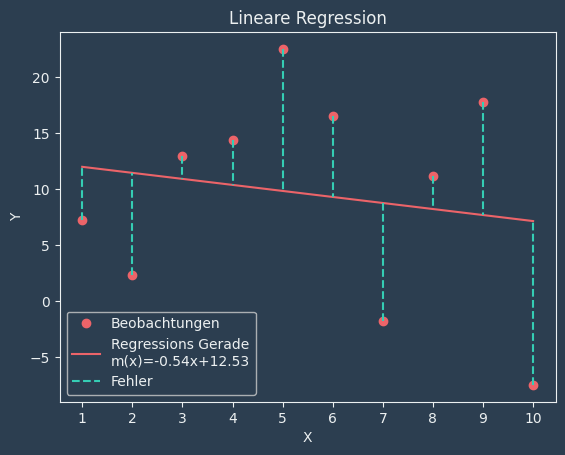

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data for demonstration
#np.random.seed(0)
x = np.linspace(1, 10, 10)  # x coordinates
y = 2 * x + np.random.normal(0, 10, 10)  # y coordinates with some random noise

# Perform linear regression
coefficients = np.polyfit(x, y, 1)
regression_line = np.poly1d(coefficients)

# Calculate errors
errors = y - regression_line(x)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the observations
ax.plot(x, y, 'o',color='C1', label='Beobachtungen')

# Plot the regression line
ax.plot(x, regression_line(x), '-', color='C1',label='Regressions Gerade\nm(x)='+"{:.2f}".format(coefficients[0])+'x'+"{:+.2f}".format(coefficients[1]))

# Plot the error bars
ax.vlines(x, y, regression_line(x), color='C2', linestyle='--', label='Fehler')

# Set ticks on the x-axis
ax.set_xticks(x)

# Add legend and labels
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Lineare Regression')

# Display the plot
plt.show()


Wie erlernen wir $w$ und $b$?

Zunächst vereinfachen der Notation:
können Eingabe $x$ um eine weitere Dimension $x_0=1$ ergänzen 

$$wx+b=<\begin{pmatrix}w_n \\ \vdots \\ w_1 \\ b\end{pmatrix},\begin{pmatrix}x_n \\ \vdots \\ x_1 \\ 1\end{pmatrix}>$$

, damit statt zwei Parametern nur noch ein Parametervektor:

$$y=m(x,w)=<\begin{pmatrix}w_n \\ \vdots \\ w_1 \\ w_0\end{pmatrix},\begin{pmatrix}x_n \\ \vdots \\ x_1 \\ x_0\end{pmatrix}>$$


### Training über Gradientenabstieg:

 * Idee: Ableitung einer Funktion zeigt in Richtung des größten Anstiegs
 * Minimierung des Fehlers durch schrittweises Verfolgen des negativen Gradientens

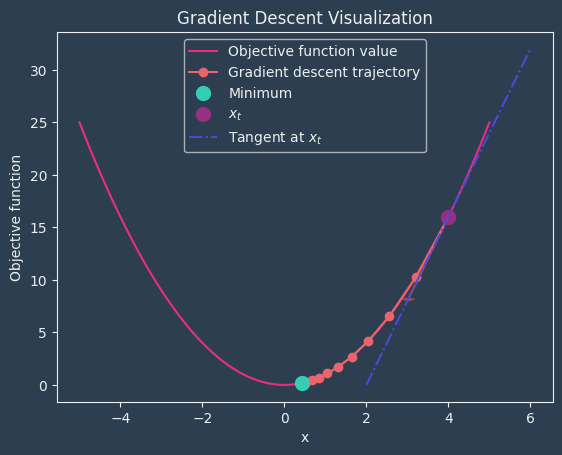

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the quadratic objective function
def objective_function(x):
    return x**2

# Define the derivative of the objective function
def derivative(x):
    return 2 * x

# Perform gradient descent
def gradient_descent(learning_rate, num_iterations):
    # Initialize variables
    x = 4  # Initial point
    trajectory = [x]
    
    # Perform iterations
    for i in range(num_iterations):
        # Compute the derivative at the current point
        dx = derivative(x)
        
        # Update the point using gradient descent
        x -= learning_rate * dx
        
        # Store the updated point in the trajectory
        trajectory.append(x)
    
    return trajectory

# Set the learning rate and number of iterations
learning_rate = 0.1
num_iterations = 10

# Perform gradient descent
trajectory = gradient_descent(learning_rate, num_iterations)

# Generate points for plotting the objective function
x = np.linspace(-5, 5, 100)
y = objective_function(x)

# Plot the objective function
plt.plot(x, y, 'C3', label='Objective function value')

# Plot the trajectory of gradient descent
plt.plot(trajectory, [objective_function(point) for point in trajectory], 'C1o-', label='Gradient descent trajectory')

# Highlight the minimum point
min_point = trajectory[-1]
plt.plot(min_point, objective_function(min_point), 'C2o', markersize=10, label='Minimum')

# Choose an arbitrary point and its derivative
arbitrary_point = 4
arbitrary_derivative = derivative(arbitrary_point)

# Plot the arbitrary point
plt.plot(arbitrary_point, objective_function(arbitrary_point), 'C4o', markersize=10, label='$x_t$')

# Calculate the tangent line
tangent_x = np.linspace(arbitrary_point - 2, arbitrary_point + 2, 100)
tangent_y = objective_function(arbitrary_point) + arbitrary_derivative * (tangent_x - arbitrary_point)
# Plot the tangent line
plt.plot(tangent_x, tangent_y, 'C0', linestyle='dashdot', label='Tangent at $x_t$')

# Plot the derivative vector
arrow_start = [arbitrary_point, objective_function(arbitrary_point)]
arrow_end = [arbitrary_point - 1, objective_function(arbitrary_point) - arbitrary_derivative]
plt.arrow(arrow_start[0], arrow_start[1], arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], color='C5', width=0.02, head_width=0.3, head_length=0.2, length_includes_head=True)

# Set labels and title
plt.xlabel('x')
plt.ylabel('Objective function')
plt.title('Gradient Descent Visualization')

# Add legend
plt.legend()

# Display the plot
plt.show()


Idee für einen überwachten Lernalgorithmus für differenzierbare Modelle $m:X\rightarrow Y$:
 * setzen Trainingsdaten ein, berechnen Prognose $y=m(x_\text{train},w)$
 * messen Fehler $L(y_\text{train},m(x_\text{train},w))$
 * Bestimmen Gradient $$\nabla m(x,w)=\frac{\partial L}{\partial w}$$
 * Schrittweise Anpassung der Gewichte $w$ über Updatefunktion
   $$w^{(k+1)}=w^{(k)}-\eta^{(k)}\frac{\nabla m(x,w)}{||\nabla m(x,w)||}$$
   mit Schrittweite $\eta$ sehr klein

 * Voraussetzung: $m$ differenzierbar
 * Verarbeiten Daten in sogenannten Batches $\rightarrow$ Stochastischer Gradienten Abstieg

## Künstliches Neuron

Ist das Lineare Modell ein guter Baustein für die Aktivierungsfunktion Neuronaler Netzwerke?

* Nein, bei Verbindung von mehreren linearen Modellen nacheinander, noch immer lineares Modell
* biologische Neuronen führen Nichtlinearität ein, durch Threshold ('Feuern', wenn Signal an Rezeptoren groß genug)

* fügen nicht-linearität der Aktivierungsfunktion $\varphi$ hinzu: $o=\varphi(<w,x>)$

* Eingaben werden mit Gewichten multipliziert
* Üertragungsfunktion bildet die Summe der Eingaben
* bei Überschreiten eines Schwellwertes ist die Aktivierung $\varphi(<x,w>)$ 

* häufig $\varphi(x)=ReLU(x)=\max(0,x)$ ("Rectified Linear Unit")

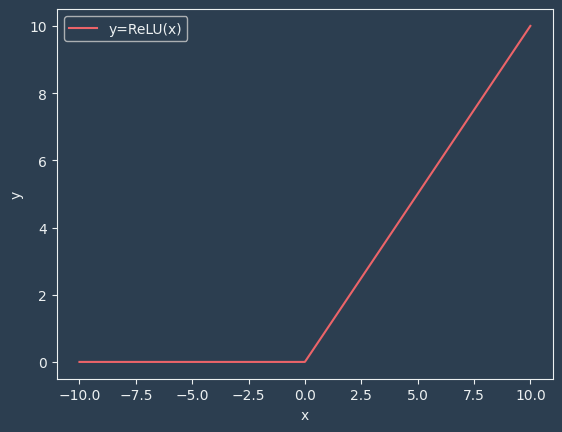

In [15]:
x = np.linspace(-10, 10, 1000)
y = np.maximum(0, x)
 
fig, ax = plt.subplots()

#ax.figure(figsize=(10, 5))
ax.plot(x, y,color='C1')
ax.legend(['y=ReLU(x)'])
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

oder Sigmoid $y=\sigma(x)=\frac{1}{1+e^{-x}}$

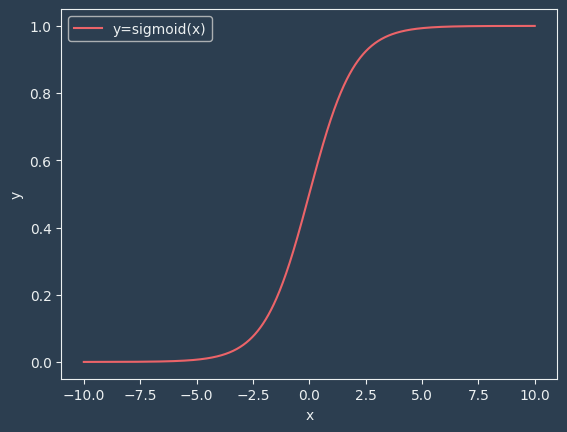

In [16]:
x = np.linspace(-10, 10, 1000)
y = 1 / (1 + np.exp(-x) )

fig, ax = plt.subplots()

ax.plot(x, y,color='C1')
ax.legend(['y=sigmoid(x)'])
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

### Threshold als zusätzliche Eingabe

In [17]:
%%html
<iframe width="100%" height="500" src="https://chokkan.github.io/deeplearning/demo-slp.html" title="Perceptron" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Expressivität

Das Perceptron lernt einen Falz

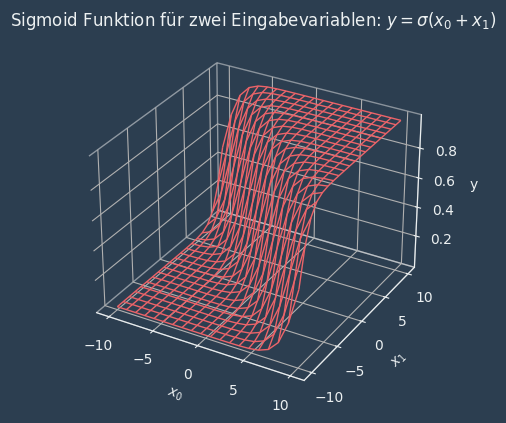

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate data
x = np.linspace(-10, 10, 20)
y = np.linspace(-10, 10, 20)
x, y = np.meshgrid(x, y)
z = sigmoid(x + y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the sigmoid function
ax.plot_wireframe(x, y, z, color='C1', linewidth=1)
ax.set_facecolor((0,0,0,0))
# Set the pane color to transparent (alpha=0) and disable grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Set labels and title
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('y')
ax.set_title('Sigmoid Funktion für zwei Eingabevariablen: $y = σ(x_0 + x_1)$')

# Display the plot
plt.show()


 * ein Perzeptron mit zwei Eingaben kann logische Funktionen erlernen `AND` `OR`, jedoch kein `XOR`

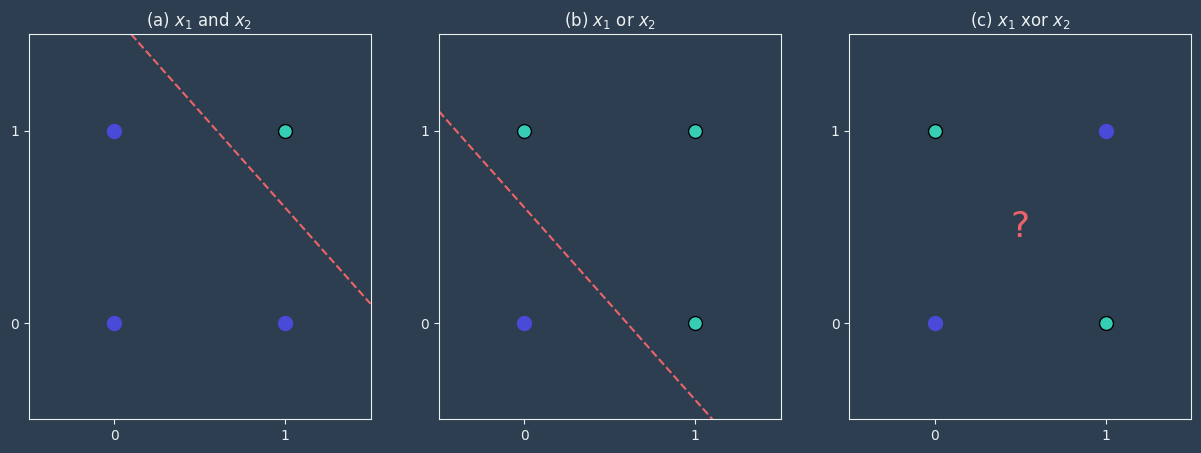

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the logic gates
def plot_logic_gates():
    # Define the points for the gates
    points = {
        'and': [(0, 0), (0, 1), (1, 0)],
        'or': [(0, 0), (0, 1), (1, 0), (1, 1)],
        'xor': [(0, 0), (1, 1)]
    }

    # Define the colors and markers for different points
    colors = {'filled': 'C0', 'empty': 'C2'}
    markers = {'filled': 'o', 'empty': 'o'}

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Plotting each gate
    for i, (key, pts) in enumerate(points.items()):
        ax[i].set_xlim(-0.5, 1.5)
        ax[i].set_ylim(-0.5, 1.5)
        ax[i].set_xticks([0, 1])
        ax[i].set_yticks([0, 1])
        ax[i].set_title(f'({chr(97+i)}) $x_1$ {key} $x_2$')

        for pt in pts:
            ax[i].plot(pt[0], pt[1], marker=markers['filled'], markersize=10, color=colors['filled'])
        
        # Special cases for each logic gate
        if key == 'and':
            #ax[i].plot(1, 1, marker=markers['filled'], markersize=10, color=colors['filled'])
            ax[i].plot(1, 1, marker=markers['empty'], markersize=10, markeredgecolor='black', color=colors['empty'])
        elif key == 'or':
            ax[i].plot(1, 0, marker=markers['empty'], markersize=10, markeredgecolor='black', color=colors['empty'])
            ax[i].plot(1, 1, marker=markers['empty'], markersize=10, markeredgecolor='black', color=colors['empty'])
            ax[i].plot(0, 1, marker=markers['empty'], markersize=10, markeredgecolor='black', color=colors['empty'])

        elif key == 'xor':
            ax[i].plot(0, 1, marker=markers['empty'], markersize=10, markeredgecolor='black', color=colors['empty'])
            ax[i].plot(1, 0, marker=markers['empty'], markersize=10, markeredgecolor='black', color=colors['empty'])

    # Plot additional lines for separating areas if necessary
    ax[0].plot([0.1, 1.5], [1.5, 0.1], '--',color='C1')  # for AND
    ax[1].plot([-0.5, 1.1], [1.1, -0.5], '--',color='C1')  # for OR
    #ax[2].plot([-0.5, 1.5], [-0.5, 1.5], 'k--')
    ax[2].text(0.5, 0.5, '?', fontsize=26, ha='center', va='center',color='C1')


    plt.show()

plot_logic_gates()


 * brauchen mehrere Schichten

Delta Regel zum Lernen des Perceptrons aus Trainingsdaten

Fehler für ein Beispiel $(x,y)$

$$
\text{RSS} = 1/2 \text{Err}^2=1/2 (y-f(x))^2
$$

Optimierung der Gewichte mit Gradientenabstieg
\begin{align*}
\frac{\partial \text{RSS}}{\partial W_j} &= \text{Err} \times \frac{\partial \text{Err}}{\partial W_j} \\
&= \text{Err} \times \frac{\partial (y-\varphi \sum_{j=0}^{n}W_jx_j)}{\partial W_j}  \\
&= -\text{Err} \times \varphi'(in) \times x_j 
%\mP(\bX \in S) &= \int_S \frac{\dd \mP \circ \bX^{-1}}{\dd \nu} \dd \nu = \int_S p \dd \nu\\
%&\\
%p(\bX=\bx\mid\bY=\by) &= \frac{ p(\bX=\bx, \bY=\by) }{p_{\bY}(\by)}\\
%&\\
%\mE[\phi(\bX)] &= \int_{\cX} \phi \dd \nu
\end{align*}

Gewichtsupdate

$$
W_j^{t+1} = W_j^{t} + \eta \times \text{Err} \times \varphi'(in) \times x_j
$$

### Multi-Layer Perceptron

In [20]:
%%html
<iframe width="100%" height="500" src="https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.83016&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false" title="Perceptron" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Beobachtung der Expressivität:
 * ein Multi-Layer-Perzeptron mit drei Schichten und ausreichend Neuronen kann alle differenzierbaren Funktionen erlernen

Lernen der Gewichte des Multi-Layer-Perceptrons mittels **Back Propagation**

Output Layer ist wie beim Perceptron
$$
W_{j,i}^{t+1} = W_{j,i}^{t} + \eta \times a_j \times \Delta_i 
$$
$$
\Delta_i = \text{Err}_i \times \varphi'(in_i) 
$$

Versteckte Schichten propagieren den Fehler zurück

$$
\Delta_j =  \varphi'(in_j) \sum_i W_{j,i} \Delta_i
$$

Mit dieser Updateregel
$$
W_{k,j}^{t+1} = W_{k,j}^{t} + \eta \times a_k \times \Delta_j 
$$

Zusammenfassung Feed Forward Neuronale Netzwerke
* Geeignet um jede differenzierbare Funktion zu erlernen
* Können sowohl für Regressions- als auch Klassifikationsproblemen genutzt werden
* Werden mit Stochastischen Gradientenabstieg trainiert


## Neuronale Netzwerke zur Bildklassifikation

Bilder werden im Computer repräsentiert durch Pixel.
* pro Pixel 3 Zahlwerte: Helligeiten von rot, grün, blau
* für 800x600 Pixel Bild 1.440.000 Zahlen


Wollen die Aufgabe lösen: Erkenne, ob ein Mensch auf dem Bild ist.


Dabei zwei Herausforderungen:
* Jedes Foto ist ein Datenpunkt mit 1.440.000 Dimensionen, sehr sehr viele Fotos notwendig zum Lernen (Fluch der hohen Dimension)
* Verschiebungen
  - grundsätzlich kann ein Neuronales Netzwerk die Gewichtskombinationen zum Erkennen eines Menschen erlernen. Menschen können sich jedoch an vielen verschiedenen Positionen im Bild befinden. 
  - Wenn für jedes Pixel ein Neuron verwendet wird, muss für jede Position des Menschen neu gelernt werden
  
Lösung: Faltungsnetzwerke

## Faltungsnetzwerke (CNN Convolutional Neural Networks)

Idee:
* Falten der Eingabe mit mehreren Filtern
* lokales rezeptives Feld verschiebt erlernte Gewichte über das Bild, und scannt nach dem erlernten Muster

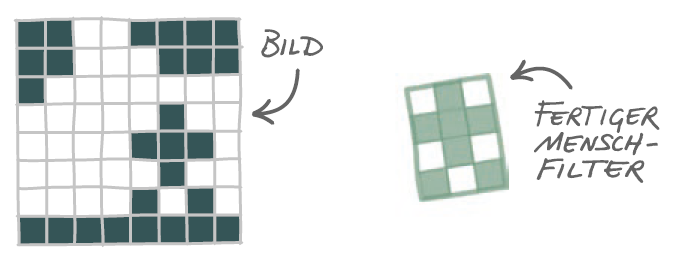
Funktionsweise der Ausgabe
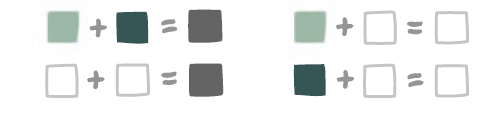
<div class="alert alert-block alert-info"> Kersting, Kristian, Christoph Lampert, and Constantin Rothkopf. Wie Maschinen lernen. Wiesbaden: Springer, 2019. </div>

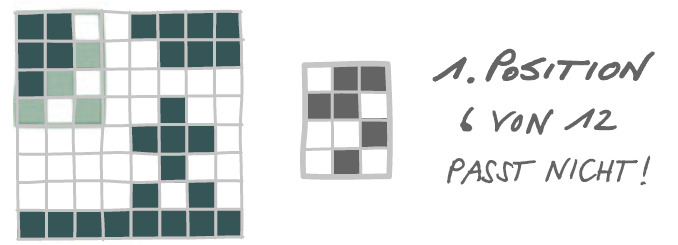
<div class="alert alert-block alert-info"> Kersting, Kristian, Christoph Lampert, and Constantin Rothkopf. Wie Maschinen lernen. Wiesbaden: Springer, 2019. </div>

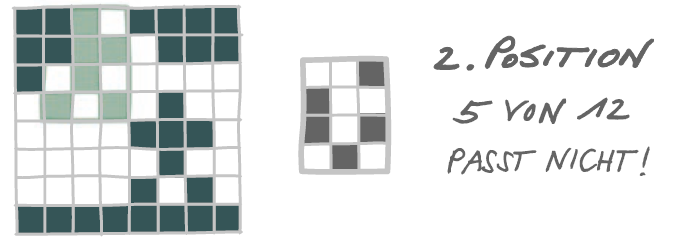
<div class="alert alert-block alert-info"> Kersting, Kristian, Christoph Lampert, and Constantin Rothkopf. Wie Maschinen lernen. Wiesbaden: Springer, 2019. </div>

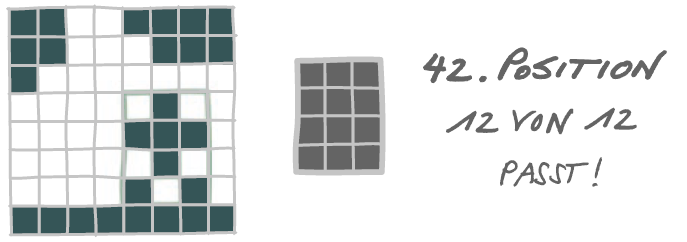
<div class="alert alert-block alert-info"> Kersting, Kristian, Christoph Lampert, and Constantin Rothkopf. Wie Maschinen lernen. Wiesbaden: Springer, 2019. </div>

### Berechnung der Faltung

![Convolution](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif "convolution")

<div class="alert alert-block alert-info"> <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)"> Wikipedia Image processing)</a> </div>

In [3]:
!pip install opencv-python  > /dev/null 2>&1

In [22]:
!pip install pandas  > /dev/null 2>&1

In [23]:
!pip install panel  > /dev/null 2>&1

In [24]:
!pip install ipywidgets  > /dev/null 2>&1

In [25]:
!jupyter nbextension enable --py widgetsnbextension  > /dev/null 2>&1

In [26]:
!pip install matplotlib ipywidgets  > /dev/null 2>&1

In [27]:
!jupyter nbextension enable --py widgetsnbextension  > /dev/null 2>&1

Example Convolution of an Image

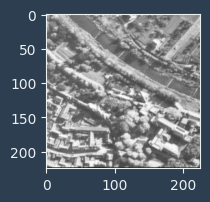

[probiere auch diese Beispielfilter...](https://en.wikipedia.org/wiki/Kernel_(image_processing)#Details)

Tabulator(value=   0  1  2
0  ...)

In [5]:
import cv2 # load necessary libraries for image processing
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

%matplotlib inline

#display(Markdown('*Eingabebild*'))

img = cv2.resize(cv2.imread('5.1.10.png', 0), (225,225))
#plt.imshow(img, cmap='gray')
fig, ax = plt.subplots(figsize=(4, 2))  # Halved from an original (8, 4) for a 50% reduction
ax.imshow(img, cmap='gray')

plt.show()

filter = np.array([[ -0,  -1, -0],
                   [  -1,  8 , -1],
                   [ -0,  -1, -0]])

import pandas as pd
import panel as pn
import numpy as np
pn.extension('tabulator')

sel_df = pd.DataFrame(filter)#, columns=list('ABCDE'))

select_table = pn.widgets.Tabulator(sel_df)
#def click(event):
#    print(f'Clicked cell in {event.column!r} column, row {event.row!r} with value {event.value!r}')

#select_table.on_click(click) 
#display(Markdown('*Filter*'))
display(Markdown('[probiere auch diese Beispielfilter...](https://en.wikipedia.org/wiki/Kernel_(image_processing)#Details)'))

select_table


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

# Create the widget button
button = widgets.Button(description='Berechne Faltung')
# Define the button handler function
def button_handler(button):
    clear_output(wait=True)
    display(button)
    filter = select_table.value.to_numpy()
    #plt.clf()

    fig, ax = plt.subplots(figsize=(8, 4))

    def convolution(img_slice, kernel):
        conv_img = 0
        conv_img = np.multiply(img_slice, kernel)
        conv_img = np.sum(conv_img)
        return conv_img

    convoled_img = np.zeros(shape=(223, 223))
    for i in range(img.shape[0] - 2):
        for j in range(img.shape[1] - 2):
            img_slice = img[i:i + 3, j:j + 3]
            convoled_img[i, j] = convolution(img_slice, filter)

    # Clear previous plot
    #plt.cla()
    #plt.close()

    # Plot the updated image
    ax.imshow(convoled_img, cmap='gray')
    plt.show()
    
# Attach the button handler function to the button's on_click event
button.on_click(button_handler)

# Display the button
display(button)


Button(description='Berechne Faltung', style=ButtonStyle())

In [7]:
%%html
<iframe width="100%" height="500px" src="https://poloclub.github.io/cnn-explainer/" title="Perceptron" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Beobachtungen Faltungsnetze:
* die Tiefe der Layer erhöht das Abstraktionslevel der internen Repräsentation
* erstes Layer
  - Gabor Filter
  - Color Blobs
  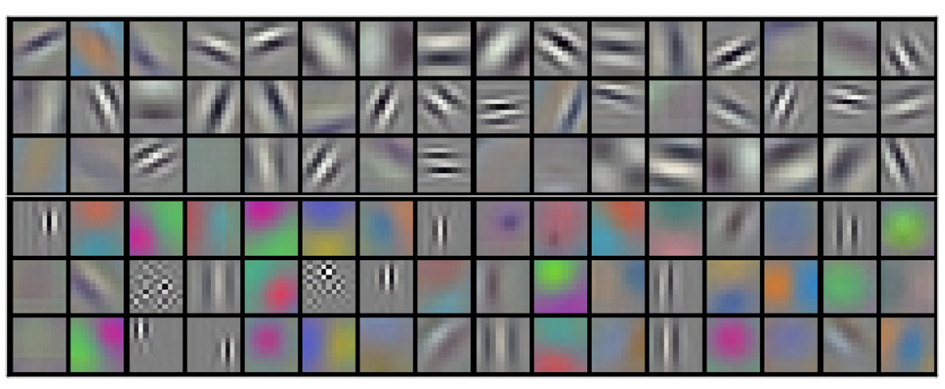
* trainierbar über Gradienten Abstieg

## Was haben wir bisher gelernt

* Überblick über Überwachtes Lernen
* Optimierungsverfahren von Modellen
* Familie der differenzierbare Modelle als Neuronale Netzwerke kennengelernt
  - Perzeptron, als Baustein 
  - Mehrlagiges Perzeptron
* Faltungsnetzwerk als ein Spezialfall der Neuronalen Netzwerke
  - Kernel wird erlernt und erlaubt wiederverwendung der Gewichte
  - Tiefe des Netzwerkes ist für Abstraktion wichtig

## Transformer Modelle

### Motivation Transformer

* Transformers wurden für Übersetzungsaufgaben (Sequenz zu Sequenz) entwickelt 
* weitere Anwendungen
  - Bild Klassifikation (CoCa Transfromer)
  - Semantische Segmentierung (FD-SwinV2-G-Transformer)
  - Objekterkennung

### In diesem Abschnitt

* Wortrepräsentation
* Konzept von Transformer Architektur
  * Attention Mechanismus
  * Normalisierung von Logits mit SoftMax
* Anwendung: nächste Wort Prognose

### Anwendung: Vorhersage nächstes Wort



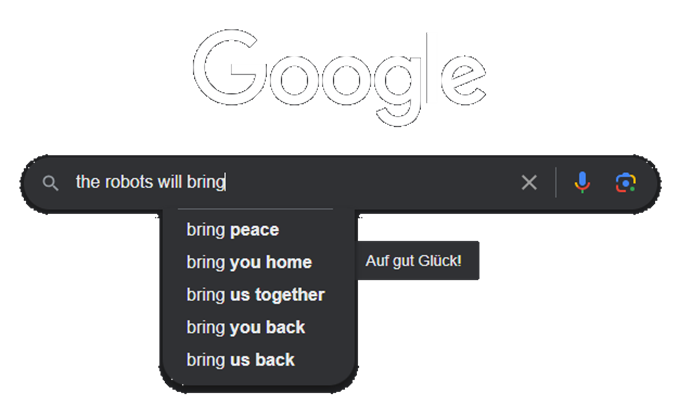

* Vorhersage basiert auf $n$ letzten Wörtern
* benötigt Beobachtungen in den Daten

$\Rightarrow$ brauchen stattdessen Fokussierung auf wesentliche Wörter in Eingabesequenz

$\Rightarrow$ Attention Mechanismus im Transformer bringt genau diese

### Konzept der Transformer Architektur


Der Transformer kann als Funktion betrachtet werden, die auf eine Eingabesequenz angewendet wird.  
* 𝑇𝑟𝑎𝑛𝑠𝑓𝑜𝑟𝑚𝑒𝑟(𝑋,𝜃)→𝑌

* 𝑋  wird in Folge von Token (eindeudig identifizierende Zahlen) umgewandelt
* 𝜃  sind die Modellparameter (die Gewichte) die auf Trainingsdaten erlernt werden

Aufgabe:

Setze „The robots will bring ___“ fort.


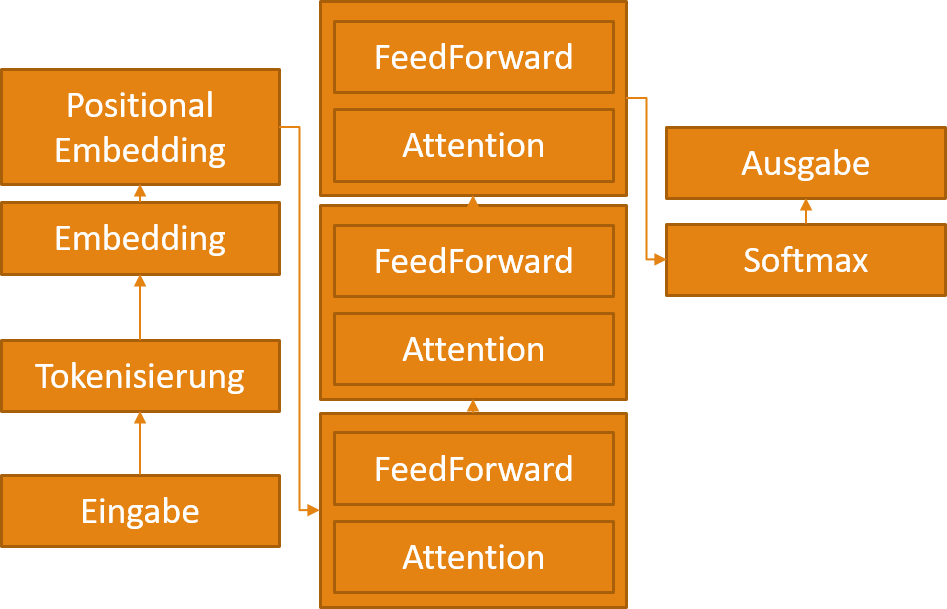

In [29]:
%manim -v WARNING --disable_caching --progress_bar None -qm TransformerFunc

### Softmax – Wahrscheinlichkeiten aus einem Neuronalen Netzwerk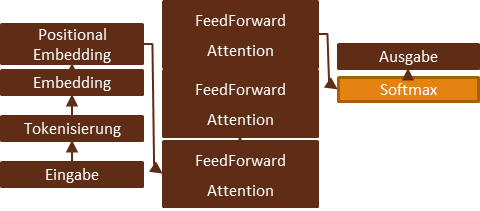

* Neuronale Netzwerke geben beliebige Zahlenwerte aus
* Wir benötigen in der letzten Schicht eine Ausgabe eines Wortes oder eine Wahrscheinlichkeits Verteilung

* Wie können wir das Normalisieren?

$$
\operatorname{softmax}(y)=\frac{e^{y_i}}{\sum e^{y_i}} 
$$

$\Rightarrow$ Wahrscheinlichkeitsverteilung über die Ausgabe
* Differenzierbar, also trainierbar mit Backpropagation

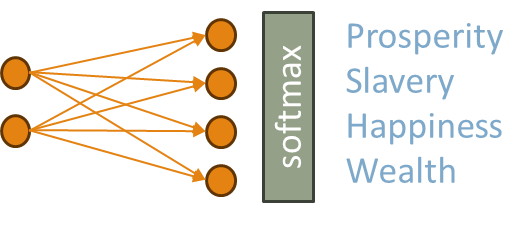

### Schritt1: Tokenisierung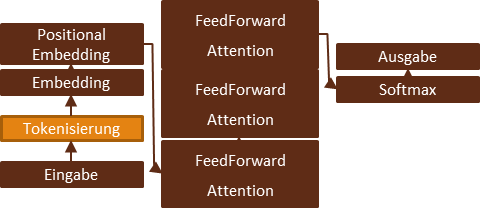

* Der Transformer arbeitet mit **Sequenzen von Zahlen**.
* Erster Schritt: **Tokenisierung** der gegebenen Eingabesequenz.
* Eingabe an das Modell erfolgt als **Sequenz von Tokens**.
* Naiver Ansatz: **jedes Wort** im Satz als **Token** behandeln.
* Das Modell versteht also keine Wörter direkt
* Modell identifiziert **Tokens anhand einer eindeutigen Nummer**.

* Vorgehensweise:
  * Naiv: Jedes Wort im **Wörterbuch** erhält eine **eindeutige Nummer**.
  * Ausgabe ist ebenfalls ein Token


In [30]:
%manim -v WARNING --disable_caching --progress_bar None -qm Vocabulary

### Schritt 2a: Token Einbettung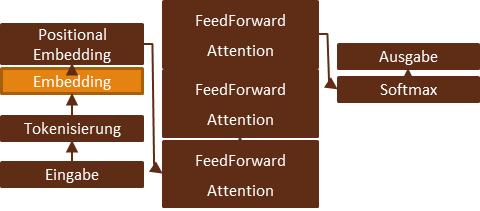

* Neuronale Netzwerke Verarbeiten Vektoren
* Token-Embedding: Jeder Token wird durch einen Vektor repräsentiert.
* Das Embedding erfasst die semantische Bedeutung eines Tokens.
* Ähnliche Tokens haben ähnliche Embeddings.
* Der Transformer im Beispiel verwendet Einbettungsvektoren der Länge 768.
* Alle Einbettungen werden in einer einzigen Matrix zusammengefasst: 𝑇×𝐶 -Matrix:
  * 𝑇=4 : Anzahl der Eingabetoken.
  * 𝐶=768 : Größe jedes Einbettungsvektors.

In [31]:
%manim -v WARNING --disable_caching --progress_bar None -qm WordEmbeddings

### Schritt2b: Positions Einbettung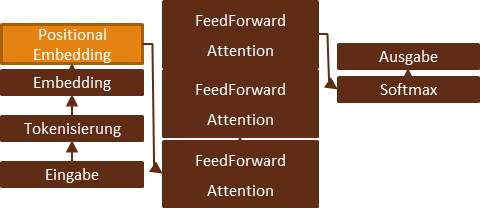

* Codierung der Position des Tokens in der Eingabesequenz

In [32]:
%manim -v WARNING --disable_caching --progress_bar None -qm PositionEmbeddings


### Schritt 2: Addition der Einbettungen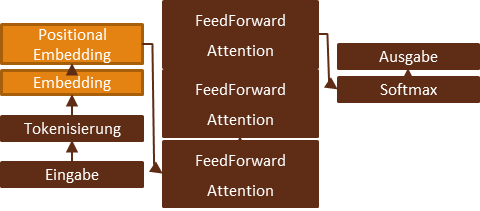

In [33]:
%manim -v WARNING --disable_caching --progress_bar None -qm PreparingEmbeddings

### Schritt 3: Self Attention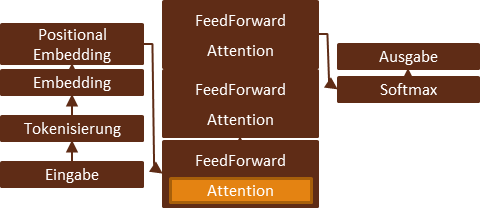

* Kontext hat Einfluss auf die Wörter
  * Apple kann nah bei Früchten sein
  * Apple kann aber auch nah bei Computerbrands sein

* Das muss sich im Embedding wiederspiegeln
  * Kontext erzeugt eine Gravitation auf das Wort zu ähnlichen Wörtern
  
    $$
    \operatorname{Similarity}(e_1,e_2)=\frac{e_1e_2^T}{\sqrt{d_e}} 
    $$
  
  * Kompression der paarweisen Ähnlichkeit zu einem kleineren Skalarprodukt von query Q, key K Werten


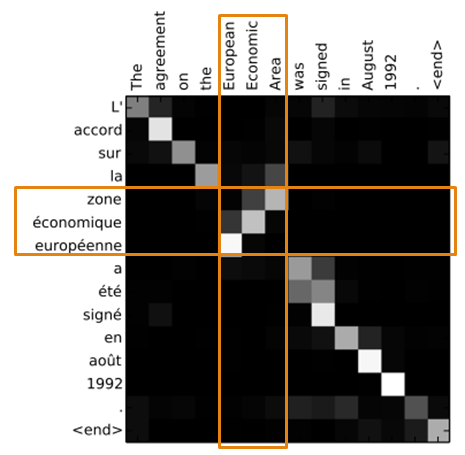

Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio: Neural Machine Translation by Jointly Learning to Align and Translate. ICLR 2015

Beispiel für Self Attention

* Die Ausgabe für ein Token ist eine gewichtete Summe der Wertevektoren.
* Beispiel: Token „Robots“:
  * Ausgabe ist eine gewichtete Summe der Wertevektoren von:
  * Dem vorherigen Token „the“.
  * Dem Token „Robots“ selbst.
* In diesem Fall:
  * Gewichtung für „the“: 47%.
  * Gewichtung für den eigenen Wertevektor: 53%.
* Diese Gewichtungen entstehen durch die Matrixmultiplikation zwischen der Aufmerksamkeitsmatrix (𝐴) und der Wertematrix (𝑉).

In [34]:
%manim -v WARNING --disable_caching --progress_bar None -qm SelfAttn

In [35]:
%manim -v WARNING --disable_caching --progress_bar None -qm SelfAttnPt2

### Query, Key, Value eine Datenbank Analogie 

Eine Analogie zur Verdeutlichung
* Datenbank mit Bildern und Textbeschreibungen.
  * Benutzereingabe: Textabfrage (die Abfrage).
  * Datenbankeintrag: Textbeschreibung (der Schlüssel).
  * Ergebnis: Das passende Bild (der Wert).

Benutzer gibt einen Text ein (Abfrage)
* Dieser Text wird mit den Textbeschreibungen der Datenbank abgeglichen (Schlüssel).
* Nur die Bilder (Werte) werden angezeigt, deren Textbeschreibung am besten zur Abfrage passt.

Selbstaufmerksamkeit funktioniert ähnlich
* Die Token in der Benutzereingabe versuchen, andere Token abzufragen.
* Ziel: Finden der Tokens, denen sie Aufmerksamkeit schenken sollten.

In [36]:
%manim -v WARNING --disable_caching --progress_bar None -qm QueryKeyValue

### FeedForward Netzwerk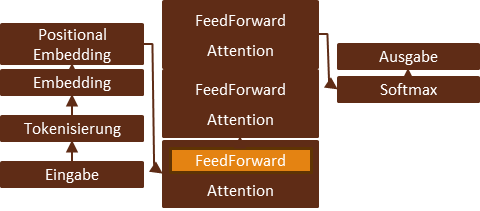

- Bisher wurden nur **lineare Operationen** durchgeführt (Matrixmultiplikationen).
- **Lineare Operationen** allein reichen nicht aus, um **komplexe Beziehungen** zwischen Tokens zu erfassen.

$\Rightarrow$ Lösung: Neuronales Netzwerk (Feedforward-Netzwerk / MLP)

- Der Transformer fügt ein **Feedforward-Netzwerk** mit einer **verborgenen Schicht** hinzu.
  - Auch bekannt als **Multi-Layer-Perceptron (MLP)**.
  - Eine **Nichtlinearität** (z. B. **ReLU**) wird eingeführt, um komplexe Beziehungen zu modellieren.


Zusammenfassung bis hierher

- Ausgangspunkt: **$T \times C$ Eingabematrix**, die die **Token- und Positions-Einbettungen** enthält.
- Bisher haben wir drei **$T \times C$ Matrizen** berechnet:
  1. **Abfragematrix (Q)**
  2. **Schlüsselmatrix (K)**
  3. **Wertematrix (V)**

Als nächstes Aufteilung in „Köpfe“

- Der Transformer teilt diese Matrizen in mehrere sogenannte **„Köpfe“** auf.
  - Jeder Kopf verarbeitet einen Teil der Informationen separat.



In [37]:
%manim -v WARNING --disable_caching --progress_bar None -qm FeedFwd

### Mehrere Schichten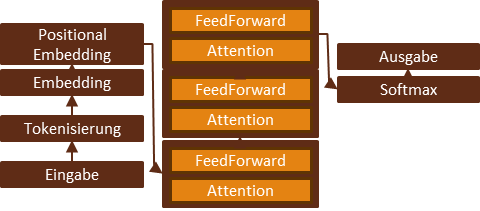


* Viele Transformer-Blöcke werden nacheinander gestapelt um komplexe Beziehungen zu modellieren

* Jeder Block baut auf der Ausgabe des vorherigen Blocks auf.


In [38]:
%manim -v WARNING --disable_caching --progress_bar None -qm GoingDeeper

### Vorhersage des nächsten Tokens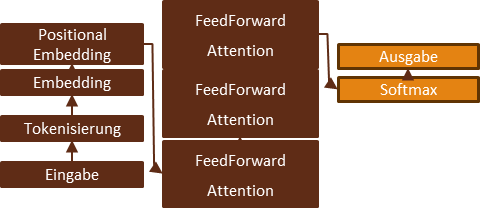

- **Letzte Ausgabe** des letzten Transformer-Blocks: Ein **Vektor der Länge $C$** für jedes Eingabetoken.
- Interessant für uns: Der Vektor des letzten Tokens **„bring“**.

##### Lineare Transformation für Vorhersage

- Eine **lineare Transformation** des Vektors:
  - Multipliziert mit einer **Gewichtsmatrix** der Dimensionen **$V \times C$**.
  - $V$: Anzahl der Wörter im **Wörterbuch**.
- Ergebnis: Ein **Vektor der Länge $V$**, der eine Wahrscheinlichkeitsverteilung über alle Wörter im Wörterbuch darstellt.

##### Auswahl des nächsten Tokens

- Nach **Normalisierung** des Vektors erhalten wir eine **Wahrscheinlichkeitsverteilung**:
  - Ermöglicht die Wahl des Wortes mit der **höchsten Wahrscheinlichkeit** als nächstes Token.

In [39]:
%manim -v WARNING --disable_caching --progress_bar None -qm Prediction

  
##### Beispiel:
- Unser Transformer sagt mit einer **Wahrscheinlichkeit von 92%**, dass **„Wohlstand“** das nächste Token ist.
- Die Wahrscheinlichkeit für **„Zerstörung“** beträgt nur **10%**.
  
##### Ergebnis:
- Der vollständige Satz lautet nun: **„Die Roboter werden Wohlstand bringen.“**
- Wir können uns beruhigt zurücklehnen, da die **KI eine Zukunft des Wohlstands** statt **Zerstörung** verspricht.


#### Textgenerierung im Transformer

- Jetzt können wir **Text generieren**, indem wir jeweils **ein Token nach dem anderen** vorhersagen.

##### Iterativer Prozess

1. Das erste **Token**, das das Modell erzeugt, wird zur **Eingabeaufforderung** hinzugefügt.
2. Dieses neue Token wird wieder als **Eingabe** verwendet, um das nächste Token zu erzeugen.
3. Dieser Vorgang wird fortgesetzt, um jedes weitere **Token** zu generieren.

In [8]:
%manim -v WARNING --disable_caching --progress_bar None -qm GeneratingText

##### Einschränkung: Maximale Anzahl von Token ($N$)

- Der Transformer hat eine **maximale Anzahl von Token ($N$)**, die er als Eingabe akzeptieren kann.
  
###### Lösungsmöglichkeiten bei langer Sequenz:

- Wenn die Anzahl der **generierten Token** die Grenze überschreitet:
  1. **Begrenzen** der Eingabe, um nur die letzten **$N$ Token** zu behalten.
  2. Eine andere Technik verwenden, um die Eingabeaufforderung zu **verkürzen**, ohne Informationen aus den ältesten Token zu verlieren.


# Seltenere Neuronale Netze

* Padé network
* Kolmogorov Arnold network
* Complex Network
* p-adic Neural Network
* Capsule Network


# List of Scenes

```bash
%%manim -v WARNING --disable_caching --progress_bar None -qm GoingDeeper

%%manim -v WARNING --disable_caching --progress_bar None -qm Prediction
%%manim -v WARNING --disable_caching --progress_bar None -qm GeneratingText
%%manim -v WARNING --disable_caching --progress_bar None -qm GoingDeeper

%%manim -v WARNING --disable_caching --progress_bar None -qm SelfAttnPt2
%%manim -v WARNING --disable_caching --progress_bar None -qm SelfAttn
%%manim -v WARNING --disable_caching --progress_bar None -qm FeedFwd
%%manim -v WARNING --disable_caching --progress_bar None -qm SelfAttnPt3
%%manim -v WARNING --disable_caching --progress_bar None -qm SplittingHeads
%%manim -v WARNING --disable_caching --progress_bar None -qm QueryKeyValue
%%manim -v WARNING --disable_caching --progress_bar None -qm Vocabulary

%%manim -v WARNING --disable_caching --progress_bar None -qm PreparingEmbeddings
%%manim -v WARNING --disable_caching --progress_bar None -qm PositionEmbeddings
%%manim -v WARNING --disable_caching --progress_bar None -qm WordEmbeddings
%%manim -v WARNING --disable_caching --progress_bar None -qm TransformerFunc
%%manim -v WARNING --disable_caching --progress_bar None -qm Vocabulary
%%manim -v WARNING --disable_caching --progress_bar None -qm TwoColumnMapping
```